<a href="https://colab.research.google.com/github/mmbs1989/TCC-PUCMINAS/blob/main/Notebook_TCC_PUC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>PUC MG - Pontifícia Universidade Católica de Minas Gerais</center></h1>

<h2><center>Pós-Graduação em Ciência de Dados e Big Data</center></h2>

<h3><center>TRABALHO DE CONCLUSÃO DE CURSO</center><br>
TÍTULO: MODELOS PREDITIVOS DA ARRECADAÇÃO FEDERAL E DE VARIÁVEIS MACROECONÔMICAS UTILIZANDO SÉRIES TEMPORAIS<br>
<br>
ALUNO: Michel Muglia Barbosa Santos</h3>


In [1]:
pip install pmdarima

     |████████████████████████████████| 1.5MB 6.1MB/s 
     |████████████████████████████████| 2.1MB 16.4MB/s 
     |████████████████████████████████| 9.5MB 35.5MB/s 
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [11]:
#Bibliotecas básicas do python
import numpy as np 
import seaborn as sns
import pandas as pd
from pandas import DataFrame
from pandas.util.testing import assert_frame_equal
from pandas_datareader import data
import matplotlib.pyplot as plt
import datetime
import math

#Bibliotecas para utilização do Prophet
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

#Bibliotecas para utilização do ARIMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import lag_plot
import pmdarima as pm
from pmdarima import auto_arima

#Bibliotecas para utilização do Keras
from keras.models import Sequential
from keras.utils import plot_model
from keras.layers import LSTM, SimpleRNN, Dense, Dropout, Masking, Embedding

#Bibliotecas para utilização das métricas do Sklearn
import sklearn.metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Bibliotecas para uso do statsmodels
import statsmodels.api as sm
from scipy import stats

#Biblioteca para ignorar os warnings
import warnings
warnings.filterwarnings("ignore")



## **CARREGAMENTO DOS DADOS E ANÁLISE EXPLORATÓRIA DA ARRECADAÇÃO FEDERAL**




In [ ]:
# Carregar bibliotecas e ler os arquivos
import pandas as pd 
dfarrec = pd.read_csv("https://raw.githubusercontent.com/mmbs1989/DSWP-Aluno/main/dadostccdata.csv")
dfa = pd.read_csv("https://raw.githubusercontent.com/mmbs1989/DSWP-Aluno/main/dadostcca.csv")

In [ ]:
# Juntar as tabelas carregadas e definir o nome da coluna
dfarrec['arrec'] = dfa['a']
dfarrec.head()

Data  arrec
0  1994-01   4836
1  1994-02   4343
2  1994-03   4418
3  1994-04   5186
4  1994-05   4732

In [ ]:
dfarrec.tail()

Data   arrec
315  2020-04  101154
316  2020-05   77415
317  2020-06   86258
318  2020-07  115990
319  2020-08  124505

In [ ]:
# Retirar as linhas que não serão utilizadas na análise
dfarrec = dfarrec.drop(dfarrec.index[314:])
dfarrec.tail()

Data   arrec
309  2019-10  135202
310  2019-11  125161
311  2019-12  147501
312  2020-01  174991
313  2020-02  116430

In [ ]:
# Transformar o tipo das colunas e definir o index
dfarrec['arrec'] = pd.to_numeric(dfarrec['arrec'])
dfarrec['Data'] = pd.to_datetime(dfarrec['Data'])
dfarrec.set_index('Data', inplace=True)

In [ ]:
dfarrec.head()

arrec
Data             
1994-01-01   4836
1994-02-01   4343
1994-03-01   4418
1994-04-01   5186
1994-05-01   4732

In [ ]:
# Estatísitica descritiva dos valores de arrecadação
dfarrec.describe()

arrec
count     314.000000
mean    54008.878981
std     42247.577509
min      4343.000000
25%     15014.500000
50%     45332.000000
75%     91308.000000
max    174991.000000

In [ ]:
# Confirmar se há valores nulos
dfarrec.isnull().sum()

arrec    0
dtype: int64

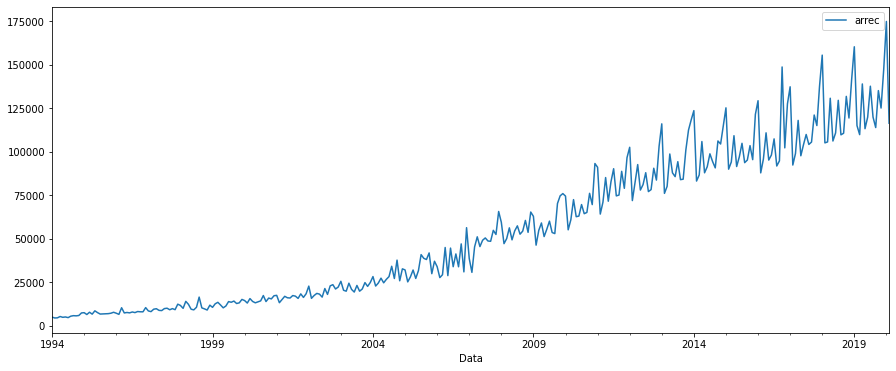

In [ ]:
# Gráfico dos valores
dfarrec.plot(figsize=(15,6))

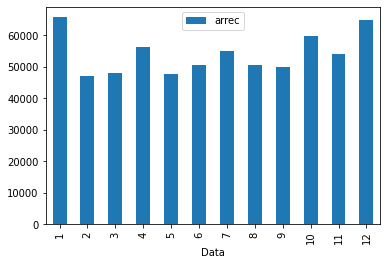

In [ ]:
# Análise dos períodos de sazonalidade
dfarrec.groupby(dfarrec.index.month).mean().plot(kind='bar')



## **CARREGAMENTO DOS DADOS E ANÁLISE EXPLORATÓRIA DO PIB**




In [3]:
# Carregar bibliotecas e ler os arquivos
import pandas as pd 
dfpib = pd.read_csv("https://raw.githubusercontent.com/mmbs1989/DSWP-Aluno/main/dadostccdata.csv")
dfp = pd.read_csv("https://raw.githubusercontent.com/mmbs1989/DSWP-Aluno/main/dadostccpib.csv")

In [4]:
# Juntar as tabelas carregadas e definir o nome da coluna
dfpib['pib'] = dfp['pib']
dfpib.head()

Data    pib
0  1994-01   4563
1  1994-02   5793
2  1994-03   8520
3  1994-04  12829
4  1994-05  20504

In [ ]:
dfpib.tail()

Data     pib
315  2020-04  543554
316  2020-05  560059
317  2020-06  605147
318  2020-07  631041
319  2020-08  629988

In [5]:
# Retirar as linhas que não serão utilizadas na análise
dfpib = dfpib.drop(dfpib.index[314:])
dfpib.tail()

Data     pib
309  2019-10  640907
310  2019-11  634654
311  2019-12  647460
312  2020-01  619785
313  2020-02  608644

In [6]:
# Transformar o tipo das colunas e definir o index
dfpib['pib'] = pd.to_numeric(dfpib['pib'])
dfpib['Data'] = pd.to_datetime(dfpib['Data'])
dfpib.set_index('Data', inplace=True)

In [7]:
dfpib.head()

pib
Data             
1994-01-01   4563
1994-02-01   5793
1994-03-01   8520
1994-04-01  12829
1994-05-01  20504

In [ ]:
# Estatísitica descritiva dos valores de arrecadação
dfpib.describe()

pib
count     314.000000
mean   269371.283439
std    184225.641732
min      4563.000000
25%    101859.000000
50%    216359.000000
75%    448483.500000
max    647460.000000

In [ ]:
# Confirmar se há valores nulos
dfpib.isnull().sum()

pib    0
dtype: int64

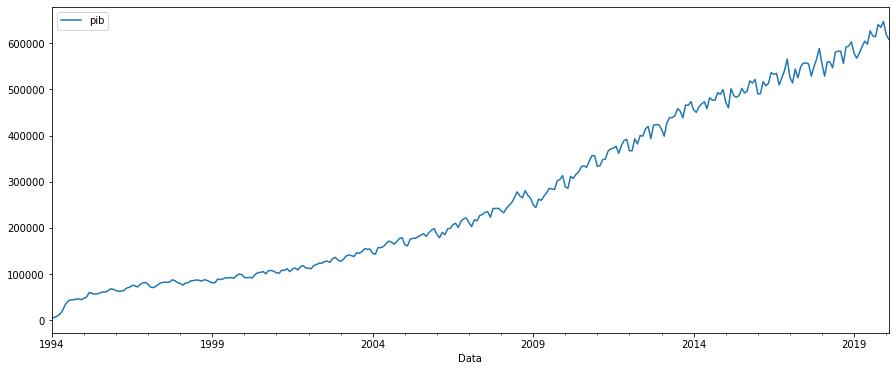

In [ ]:
# Gráfico dos valores
dfpib.plot(figsize=(15,6))

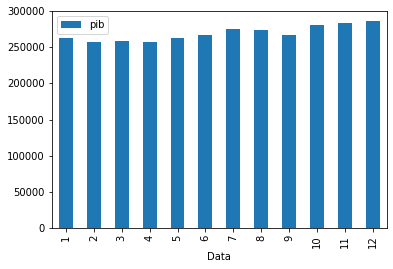

In [ ]:
# Análise dos períodos de sazonalidade
dfpib.groupby(dfpib.index.month).mean().plot(kind='bar')



## **CARREGAMENTO DOS DADOS E ANÁLISE EXPLORATÓRIA DAS IMPORTAÇÕES**




In [ ]:
# Carregar bibliotecas e ler os arquivos
import pandas as pd 
dfimp = pd.read_csv("https://raw.githubusercontent.com/mmbs1989/DSWP-Aluno/main/dadostccdata.csv")
dfi = pd.read_csv("https://raw.githubusercontent.com/mmbs1989/DSWP-Aluno/main/dadostcci.csv")

In [ ]:
# Juntar as tabelas carregadas e definir o nome da coluna
dfimp['imp'] = dfi['i']
dfimp.head()

Data         imp
0  1994-01  1768675231
1  1994-02  2030100974
2  1994-03  2248937491
3  1994-04  2151981505
4  1994-05  2624852192

In [ ]:
dfimp.tail()

Data          imp
315  2020-04  11610871137
316  2020-05  13390915390
317  2020-06  10449294354
318  2020-07  11508172753
319  2020-08  11132508190

In [ ]:
# Retirar as linhas que não serão utilizadas na análise
dfimp = dfimp.drop(dfimp.index[314:])
dfimp.tail()

Data          imp
309  2019-10  17027283951
310  2019-11  14172102789
311  2019-12  12556086388
312  2020-01  16178224141
313  2020-02  13257290693

In [ ]:
# Transformar o tipo das colunas e definir o index
dfimp['imp'] = pd.to_numeric(dfimp['imp'])
dfimp['Data'] = pd.to_datetime(dfimp['Data'])
dfimp.set_index('Data', inplace=True)

In [ ]:
dfimp.head()

imp
Data                  
1994-01-01  1768675231
1994-02-01  2030100974
1994-03-01  2248937491
1994-04-01  2151981505
1994-05-01  2624852192

In [ ]:
# Estatísitica descritiva dos valores de arrecadação
dfimp.describe()

imp
count  3.140000e+02
mean   9.892423e+09
std    5.810019e+09
min    1.768675e+09
25%    4.618011e+09
50%    8.533477e+09
75%    1.460153e+10
max    2.304960e+10

In [ ]:
# Confirmar se há valores nulos
dfimp.isnull().sum()

imp    0
dtype: int64

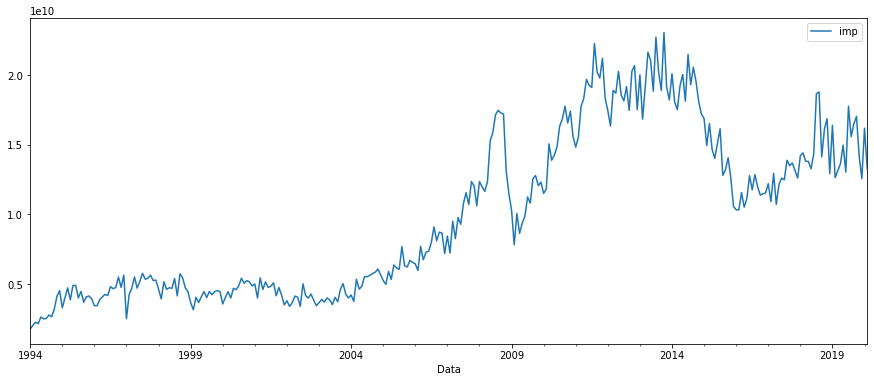

In [ ]:
# Gráfico dos valores
dfimp.plot(figsize=(15,6))

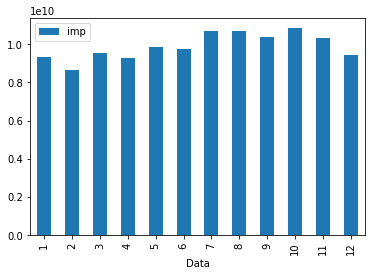

In [ ]:
# Análise dos períodos de sazonalidade
dfimp.groupby(dfimp.index.month).mean().plot(kind='bar')



## **CARREGAMENTO DOS DADOS E ANÁLISE EXPLORATÓRIA DAS EXPORTAÇÕES**




In [ ]:
# Carregar bibliotecas e ler os arquivos
import pandas as pd 
dfexp = pd.read_csv("https://raw.githubusercontent.com/mmbs1989/DSWP-Aluno/main/dadostccdata.csv")
dfe = pd.read_csv("https://raw.githubusercontent.com/mmbs1989/DSWP-Aluno/main/dadostcce.csv")

In [ ]:
# Juntar as tabelas carregadas e definir o nome da coluna
dfexp['exp'] = dfe['e']
dfexp.head()

Data         exp
0  1994-01  2747187653
1  1994-02  2778288879
2  1994-03  3350391558
3  1994-04  3634841763
4  1994-05  3862059965

In [ ]:
dfexp.tail()

Data          exp
315  2020-04  17612476835
316  2020-05  17546386795
317  2020-06  17514983082
318  2020-07  19453592020
319  2020-08  17484221076

In [ ]:
# Retirar as linhas que não serão utilizadas na análise
dfexp = dfexp.drop(dfexp.index[314:])
dfexp.tail()

Data          exp
309  2019-10  19576839231
310  2019-11  17736715198
311  2019-12  18502977191
312  2020-01  14494583508
313  2020-02  15582390653

In [ ]:
# Transformar o tipo das colunas e definir o index
dfexp['exp'] = pd.to_numeric(dfexp['exp'])
dfexp['Data'] = pd.to_datetime(dfexp['Data'])
dfexp.set_index('Data', inplace=True)

In [ ]:
dfexp.head()

exp
Data                  
1994-01-01  2747187653
1994-02-01  2778288879
1994-03-01  3350391558
1994-04-01  3634841763
1994-05-01  3862059965

In [ ]:
# Estatísitica descritiva dos valores de arrecadação
dfexp.describe()

exp
count  3.140000e+02
mean   1.164247e+10
std    6.617466e+09
min    2.747188e+09
25%    4.632934e+09
50%    1.184663e+10
75%    1.768190e+10
max    2.614824e+10

In [ ]:
# Confirmar se há valores nulos
dfexp.isnull().sum()

exp    0
dtype: int64

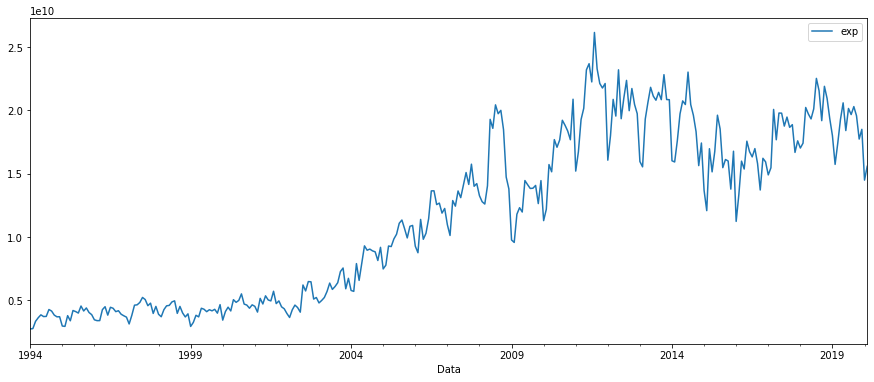

In [ ]:
# Gráfico dos valores
dfexp.plot(figsize=(15,6))

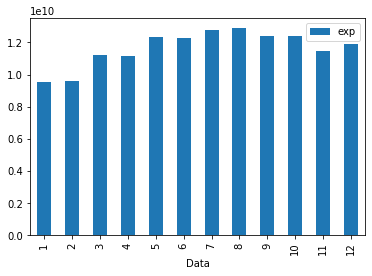

In [ ]:
# Análise dos períodos de sazonalidade
dfexp.groupby(dfexp.index.month).mean().plot(kind='bar')

In [ ]:
df.index.freq = 'MS'

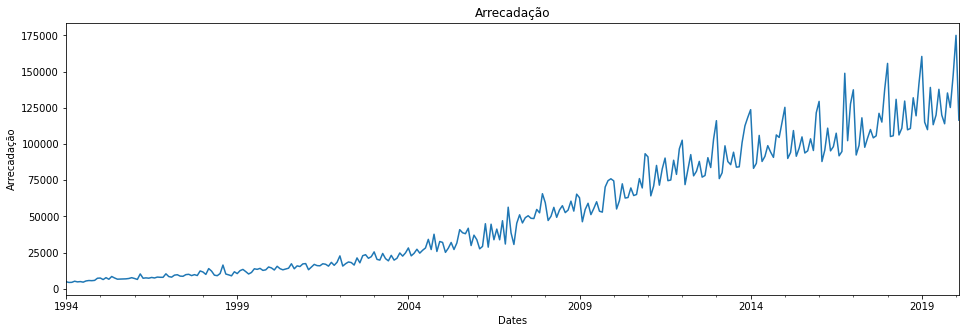

In [ ]:
ax = df['y'].plot(figsize = (16,5), title = "Arrecadação")
ax.set(xlabel='Dates', ylabel='Arrecadação');

When we look at plot we can sey there is a seasonality in data. That's why we will use SARIMA (Seasonal ARIMA) instead of ARIMA.

> Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.
> It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

> There are four seasonal elements that are not part of ARIMA that must be configured; they are:<br>
**P:** Seasonal autoregressive order.<br>
**D:** Seasonal difference order.<br>
**Q:** Seasonal moving average order.<br>
**m:** The number of time steps for a single seasonal period.<br>

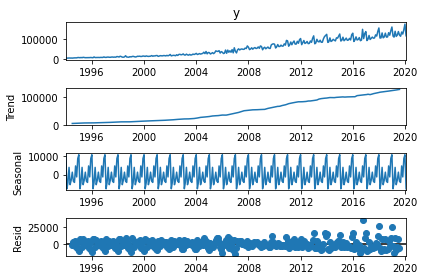

In [ ]:
a = seasonal_decompose(df["y"], model = "add")
a.plot();

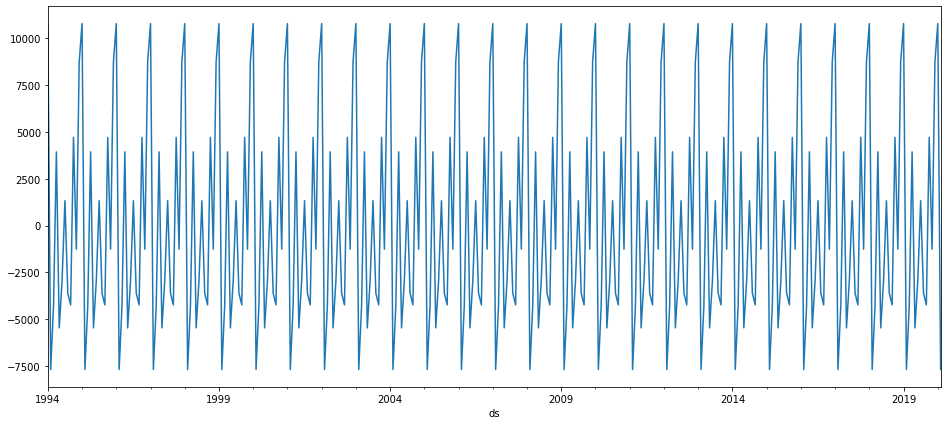

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (16,7))
a.seasonal.plot();

## **MODELOS PREDITIVOS DA ARRECADAÇÃO FEDERAL**

## Modelo preditivo ARIMA

In [ ]:
# Definição do conjunto de treinamento e do conjunto de teste
dfarrec_train_arima = dfarrec.iloc[:-14].copy()  
dfarrec_test_arima =  dfarrec.iloc[-14:].copy()

In [ ]:
# Utilização do auto-arima para identificar o melhor modelo de forma automática
model = auto_arima(dfarrec_train_arima['arrec'], start_p=1, start_q=1, max_p=3, max_q=3, d=1, stationary = False, start_P=0, D=1, trace=True,
                   error_action='ignore', suppress_warnings=True, stepwise=True, seasonal= True, m=12)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=5700.993, Time=1.27 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5922.820, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5785.124, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5699.424, Time=0.98 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=5781.815, Time=0.12 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=5699.614, Time=1.34 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=5718.844, Time=0.91 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=5720.122, Time=0.81 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=5692.038, Time=5.42 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=inf, Time=7.10 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=5719.306, Time=1.11 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=5852.188, Time=1.73 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=5694.244, Time=7.47 sec
 ARIMA(0,1,2)(1,1,2)[12]             : AIC=inf, Time=6.06 sec
 ARIMA(1,1,0)(1,1,2)[12]     

In [ ]:
print(model.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  300
Model:             SARIMAX(0, 1, 1)x(1, 1, [1, 2], 12)   Log Likelihood               -2841.019
Date:                                 Wed, 10 Feb 2021   AIC                           5692.038
Time:                                         18:51:06   BIC                           5710.336
Sample:                                              0   HQIC                          5699.372
                                                 - 300                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8176      0.030    -27.451      0.000      -0.876      -0

As we can see best arima model chosen by auto_arima() is SARIMAX(2, 1, 1)x(4, 0, 3, 12)

Let's split the data into train and test set

In [ ]:
# Treinamento do modelo
model.fit(dfarrec_train_arima['arrec'])

ARIMA(maxiter=50, method='lbfgs', order=(0, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(1, 1, 2, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [ ]:
#Faz a predição 
forecast_arima = model.predict(n_periods=len(dfarrec_test_arima['arrec']))
forecast_arima = pd.DataFrame(forecast_arima, index = dfarrec_test_arima.index,columns=['Prediction'])
conf_int = model.predict(len(dfarrec_test_arima['arrec']), return_conf_int=True, alpha = 0.05) #Pega o intervalo de confiança

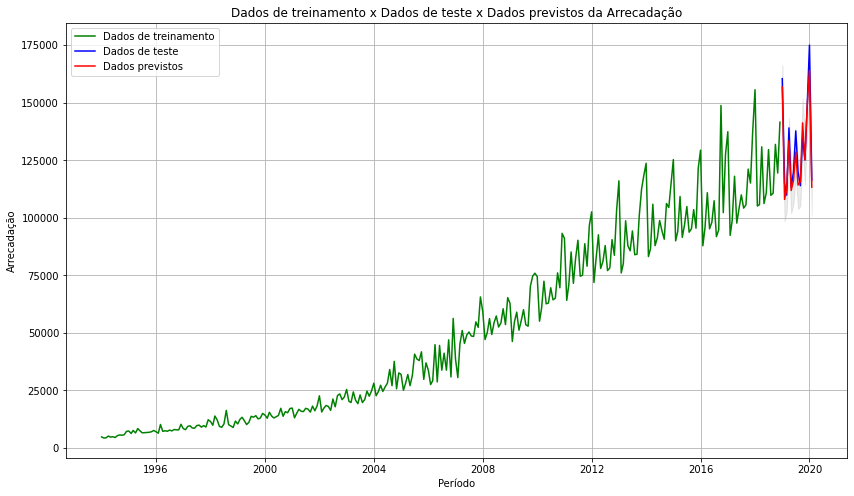

In [ ]:
#Plotagem dos dados de treinamento, teste e previsão
plt.figure(figsize=(14,8))
plt.title('Dados de treinamento x Dados de teste x Dados previstos da Arrecadação')
plt.plot(dfarrec_train_arima['arrec'], color='green', label = 'Dados de treinamento')
plt.plot(dfarrec_test_arima['arrec'], color = 'blue', label = 'Dados de teste')
plt.fill_between(dfarrec_test_arima.index, conf_int[1][:,0], conf_int[1][:,1], 
                 color='k', alpha=.08)
plt.plot(forecast_arima['Prediction'], color = 'red', label = 'Dados previstos')
plt.xlabel('Período')
plt.ylabel('Arrecadação')
plt.legend()
plt.grid(True)
#plt.savefig('arima1.pdf')
plt.show()

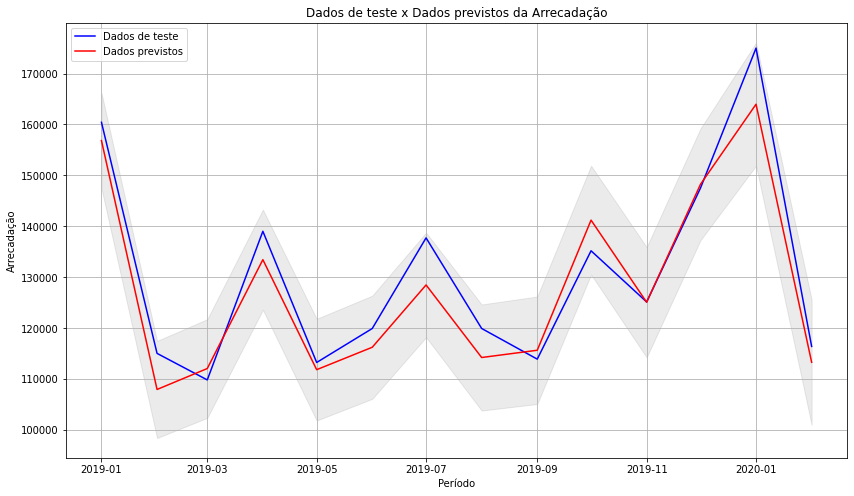

In [ ]:
#Plotagem dos dados de teste e previsão
plt.figure(figsize=(14,8))
plt.title('Dados de teste x Dados previstos da Arrecadação')
plt.plot(dfarrec_test_arima['arrec'], color = 'blue', label = 'Dados de teste')
plt.fill_between(dfarrec_test_arima.index, conf_int[1][:,0], conf_int[1][:,1], 
                 color='k', alpha=.08)
plt.plot(forecast_arima['Prediction'], color = 'red', label = 'Dados previstos')
plt.xlabel('Período')
plt.ylabel('Arrecadação')
plt.legend()
plt.grid(True)
#plt.savefig('arima2.pdf')
plt.show()

In [ ]:
#Cálculo do erro
mse = mean_squared_error(dfarrec_test_arima['arrec'], forecast_arima['Prediction'])
print('MSE: '+str(mse))
mae = mean_absolute_error(dfarrec_test_arima['arrec'], forecast_arima['Prediction'])
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(dfarrec_test_arima['arrec'], forecast_arima['Prediction']))
print('RMSE: '+str(rmse))

MSE: 28819248.34610119
MAE: 4372.347419805619
RMSE: 5368.356205217869


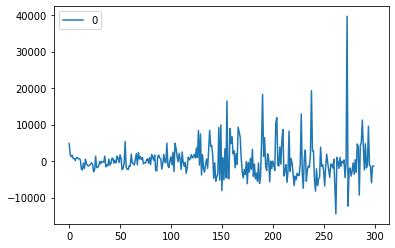

In [ ]:
#Plotagem dos resíduos
residuals = pd.DataFrame(model.resid())
residuals.plot()

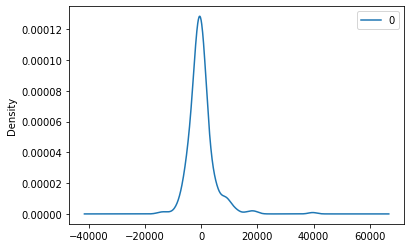

                  0
count    300.000000
mean      56.602514
std     4704.607373
min   -14453.444244
25%    -2198.874580
50%     -498.052384
75%     1283.457862
max    39674.756618


In [ ]:
#Plotagem da densidade dos resíduos
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [ ]:
test_data['ARIMA_Predictions'] = arima_pred

## Modelo Preditivo LSTM

First we'll scale our train and test data with MinMaxScaler

In [ ]:
# Definição do conjunto de treinamento e do conjunto de teste
dfarrec_train_lstm = dfarrec.iloc[:-14].copy()  
dfarrec_test_lstm =  dfarrec.iloc[-14:].copy()

In [ ]:
#Normalização dos dados
train_lstm = dfarrec_train_lstm.iloc[:,0:1].values
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_scaled_lstm = scaler.fit_transform(train_lstm) 
train_scaled_lstm

array([[3.25894392e-03],
       [0.00000000e+00],
       [4.95782543e-04],
       [5.57259579e-03],
       [2.57145879e-03],
       [3.88032470e-03],
       [1.36174939e-03],
       [6.82196779e-03],
       [8.78526666e-03],
       [8.08456067e-03],
       [9.41325789e-03],
       [1.91768688e-02],
       [2.01221608e-02],
       [1.31481530e-02],
       [2.18342632e-02],
       [1.46090589e-02],
       [2.71622729e-02],
       [2.03997990e-02],
       [1.49197493e-02],
       [1.54816362e-02],
       [1.60567440e-02],
       [1.64401491e-02],
       [1.80663159e-02],
       [2.17152754e-02],
       [1.80927576e-02],
       [1.37827547e-02],
       [3.89024036e-02],
       [1.91702583e-02],
       [2.08955816e-02],
       [1.94412861e-02],
       [2.27861657e-02],
       [2.04460721e-02],
       [2.44982681e-02],
       [2.35133134e-02],
       [2.34207673e-02],
       [3.94047965e-02],
       [2.68581930e-02],
       [2.41346942e-02],
       [3.33430286e-02],
       [3.52005606e-02],


In [ ]:
#Criação de uma estrutura de dados com 60 timesteps e 1 saída que neste caso será o preço de fechamento da ação
timesteps = 60
x_train_lstm = []
y_train_lstm = []
for i in range(timesteps, train_lstm.shape[0]):
    x_train_lstm.append(train_scaled_lstm[i-timesteps:i, 0]) #Utilização de 60 timesteps anteriores
    y_train_lstm.append(train_scaled_lstm[i, 0]) #O 120º preço de fechamento será o valor de y
x_train_lstm, y_train_lstm = np.array(x_train_lstm), np.array(y_train_lstm)

In [ ]:
x_train_lstm = np.reshape(x_train_lstm, (x_train_lstm.shape[0], x_train_lstm.shape[1], 1))

In [ ]:
#Criação da LSTM utilizando a biblioteca Keras

#seed=2016
#np.random.seed (seed)

# Inicialização da RNN
model_rnn = Sequential()

#O parâmetro return_sequences=True indica que a rede terá mais camadas a frente
#O parâmetro Dropout ajuda no ajuste do Overfitting

# Adiciona a primeira camada LSTM com o Dropout 
model_rnn.add(LSTM(units = 128, return_sequences = True, input_shape = (x_train_lstm.shape[1], 1)))
model_rnn.add(Dropout(0.3))

# Adiciona a segunda camada LSTM com o Dropout
model_rnn.add(LSTM(units = 64))
model_rnn.add(Dropout(0.3))

# Adiciona a camada de saída 
#model_rnn.add(Dense(16,init='uniform',activation='relu'))
model_rnn.add(Dense(1,activation='linear'))

# Compila a RNN, neste caso utilizando o otimizador 'Adam'
model_rnn.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mean_absolute_error'])

# Faz o treinamento da RNN utilizando o dataset de treinamento
model_rnn.fit(x_train_lstm, y_train_lstm, epochs = 100, batch_size = 32) 

#Mostra o resumo do modelo
model_rnn.summary()

Epoch 1/100
8/8 [==============================] - 4s 83ms/step - loss: 0.1093 - mean_absolute_error: 0.2504
Epoch 2/100
8/8 [==============================] - 1s 83ms/step - loss: 0.0145 - mean_absolute_error: 0.0867
Epoch 3/100
8/8 [==============================] - 1s 82ms/step - loss: 0.0089 - mean_absolute_error: 0.0735
Epoch 4/100
8/8 [==============================] - 1s 82ms/step - loss: 0.0095 - mean_absolute_error: 0.0723
Epoch 5/100
8/8 [==============================] - 1s 83ms/step - loss: 0.0071 - mean_absolute_error: 0.0575
Epoch 6/100
8/8 [==============================] - 1s 81ms/step - loss: 0.0050 - mean_absolute_error: 0.0490
Epoch 7/100
8/8 [==============================] - 1s 84ms/step - loss: 0.0072 - mean_absolute_error: 0.0574
Epoch 8/100
8/8 [==============================] - 1s 78ms/step - loss: 0.0048 - mean_absolute_error: 0.0486
Epoch 9/100
8/8 [==============================] - 1s 81ms/step - loss: 0.0064 - mean_absolute_error: 0.0545
Epoch 10/100
8/8 [=

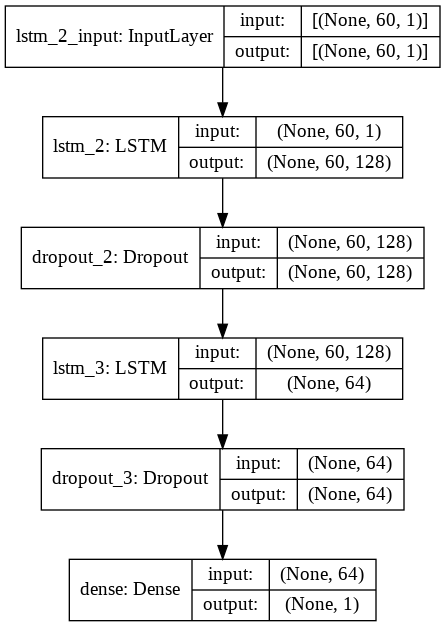

In [ ]:
#Visualização do modelo
plot_model(model_rnn, show_shapes=True) #Acrescente o parâmetro 'to_file='model_rnn.png' para exportar a figura

In [ ]:
#Carregamentos dos dados de teste para fazer as predições
test_lstm = dfarrec_test_lstm.iloc[:,0:1].values

In [ ]:
# Concatena os dados de treinamento e teste, pois os preços de fechamento anteriores não estão no conjunto de teste
combine = pd.concat((dfarrec_train_lstm['arrec'], dfarrec_test_lstm['arrec']), axis = 0)

# Tratamento do conjunto de teste considerando os timesteps anteriores
test_inputs = combine[len(combine) - len(dfarrec_test_lstm) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)

# Normalização dos dados
test_inputs = scaler.transform(test_inputs)

In [ ]:
# Predição utilizando os dados de teste
x_test_lstm = []
for i in range(timesteps, dfarrec_test_lstm.shape[0]+timesteps):
    x_test_lstm.append(test_inputs[i-timesteps:i, 0])
x_test_lstm = np.array(x_test_lstm)
x_test_lstm = np.reshape(x_test_lstm, (x_test_lstm.shape[0], x_test_lstm.shape[1], 1))
predictions_lstm = model_rnn.predict(x_test_lstm)

# Desnormaliza os dados
predictions_lstm = scaler.inverse_transform(predictions_lstm)

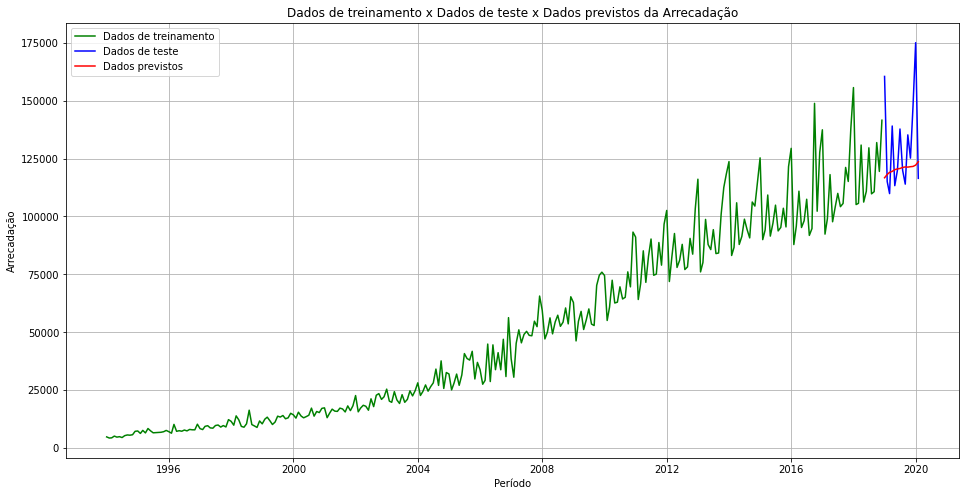

In [ ]:
#Plotagem dos dados de treinamento, teste e previsão
plt.figure(figsize=(16,8))
plt.plot(dfarrec_train_lstm.index, dfarrec_train_lstm, color='green', label = 'Dados de treinamento')
plt.plot(dfarrec_test_lstm.index, dfarrec_test_lstm, color = 'blue', label = 'Dados de teste')
plt.plot(dfarrec_test_lstm.index, predictions_lstm, color = 'red', label = 'Dados previstos')
plt.title('Dados de treinamento x Dados de teste x Dados previstos da Arrecadação')
plt.xlabel('Período')
plt.ylabel('Arrecadação')
plt.legend()
plt.grid(True)
#plt.savefig('lstm1.pdf')
plt.show()

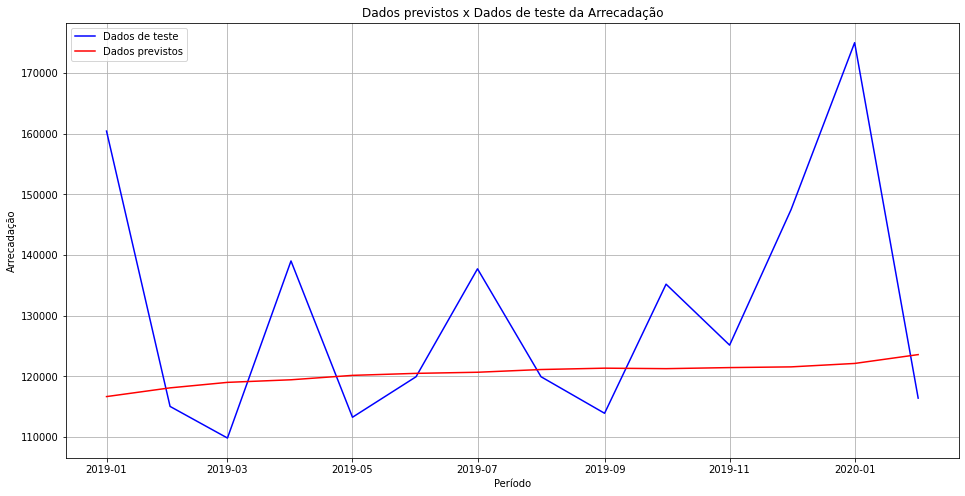

In [ ]:
#Plotagem dos dados de teste e dados previstos
plt.figure(figsize=(16,8))
plt.plot(dfarrec_test_lstm.index, test_lstm, color = 'blue', label = 'Dados de teste')
plt.plot(dfarrec_test_lstm.index, predictions_lstm, color = 'red', label = 'Dados previstos')
plt.title('Dados previstos x Dados de teste da Arrecadação')
plt.xlabel('Período')
plt.ylabel('Arrecadação')
plt.legend()
plt.grid(True)
#plt.savefig('lstm2.pdf')
plt.show()

In [ ]:
#Cálculo do erro
print('MAE: ', mean_absolute_error(dfarrec_test_lstm,predictions_lstm))
print('MSE: ', mean_squared_error(dfarrec_test_lstm,predictions_lstm))
print('RMSE: ', np.sqrt(mean_squared_error(dfarrec_test_lstm,predictions_lstm)))

MAE:  15159.853794642857
MSE:  464928611.8123169
RMSE:  21562.203315345974


In [ ]:
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

Before creating LSTM model we should create a Time Series Generator object.

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               161600    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm_model.fit_generator(generator,epochs=20)

Epoch 1/20
290/290 [==============================] - 4s 10ms/step - loss: 0.0269
Epoch 2/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0047
Epoch 3/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0073
Epoch 4/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0043
Epoch 5/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0052
Epoch 6/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0043
Epoch 7/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0039
Epoch 8/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0046
Epoch 9/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0050
Epoch 10/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0029
Epoch 11/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0020
Epoch 12/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0029
Epoch 13/20
2

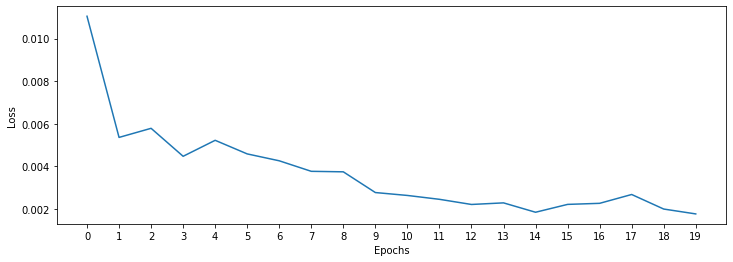

In [ ]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [ ]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

As you know we scaled our data that's why we have to inverse it to see true predictions.

In [ ]:
lstm_predictions_scaled

[array([0.7392362], dtype=float32),
 array([0.85764617], dtype=float32),
 array([0.74661165], dtype=float32),
 array([0.7634965], dtype=float32),
 array([0.8542656], dtype=float32),
 array([0.7650373], dtype=float32),
 array([0.7677406], dtype=float32),
 array([0.87268454], dtype=float32),
 array([0.8191243], dtype=float32),
 array([0.93390137], dtype=float32),
 array([1.0454565], dtype=float32),
 array([0.8151505], dtype=float32)]

In [ ]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [ ]:
lstm_predictions

array([[119725.20006078],
       [138206.9867273 ],
       [120876.38690966],
       [123511.82704008],
       [137679.33306229],
       [123752.31661534],
       [124174.25720322],
       [140554.22080153],
       [132194.37521476],
       [150109.12746686],
       [167520.99136341],
       [131574.13538909]])

In [ ]:
test_data['LSTM_Predictions'] = lstm_predictions

In [ ]:
test_data

y  ARIMA_Predictions  LSTM_Predictions
ds                                                     
2019-03-01  109854      114538.221536     119725.200061
2019-04-01  139030      136135.889426     138206.986727
2019-05-01  113278      114385.365859     120876.386910
2019-06-01  119946      119389.395546     123511.827040
2019-07-01  137735      131883.349396     137679.333062
2019-08-01  119951      117439.879777     123752.316615
2019-09-01  113933      118629.422669     124174.257203
2019-10-01  135202      143127.237904     140554.220802
2019-11-01  125161      128216.866629     132194.375215
2019-12-01  147501      151476.405793     150109.127467
2020-01-01  174991      167102.885630     167520.991363
2020-02-01  116430      118813.306616     131574.135389

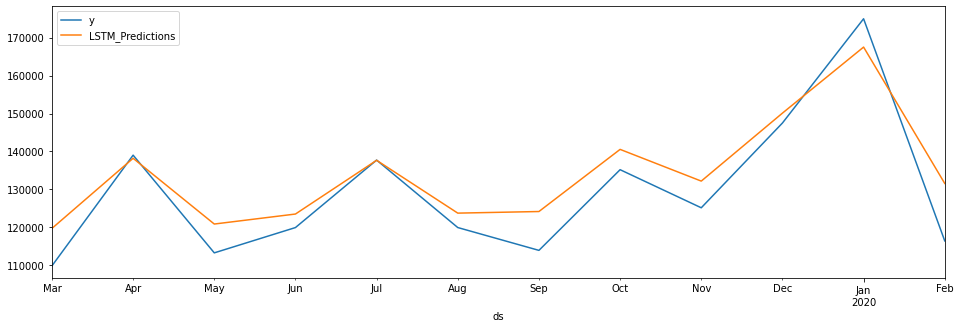

In [ ]:
test_data['y'].plot(figsize = (16,5), legend=True)
test_data['LSTM_Predictions'].plot(legend = True);

In [ ]:
lstm_rmse_error = rmse(test_data['y'], test_data["LSTM_Predictions"])
lstm_mse_error = lstm_rmse_error**2
mean_value = df['y'].mean()

print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMean: {mean_value}')

MSE Error: 54830652.711122535
RMSE Error: 7404.772292996087
Mean: 54008.87898089172


## Modelo Preditivo PROPHET

In [ ]:
# Definição do conjunto de treinamento e do conjunto de teste
dfarrec_train_prophet = dfarrec.iloc[:-14].copy()  
dfarrec_test_prophet =  dfarrec.iloc[-14:].copy()

In [ ]:
#Renomeia as colunas 'arrec' para 'y' e 'Data' para 'ds' do conjunto de treinamento e teste
dfarrec_train_prophet = pd.DataFrame({"ds": dfarrec_train_prophet.index, "y": dfarrec_train_prophet.arrec})
dfarrec_train_prophet.reset_index(drop = True, inplace = True)
dfarrec_test_prophet = pd.DataFrame({"ds_test": dfarrec_test_prophet.index, "y_test": dfarrec_test_prophet.arrec})
dfarrec_test_prophet.reset_index(drop = True, inplace = True)

In [ ]:
dfarrec_train_prophet.head()

ds     y
0 1994-01-01  4836
1 1994-02-01  4343
2 1994-03-01  4418
3 1994-04-01  5186
4 1994-05-01  4732

In [ ]:
dfarrec_test_prophet.head(30)

ds_test  y_test
0  2019-01-01  160426
1  2019-02-01  115062
2  2019-03-01  109854
3  2019-04-01  139030
4  2019-05-01  113278
5  2019-06-01  119946
6  2019-07-01  137735
7  2019-08-01  119951
8  2019-09-01  113933
9  2019-10-01  135202
10 2019-11-01  125161
11 2019-12-01  147501
12 2020-01-01  174991
13 2020-02-01  116430

In [ ]:
#Utiliza a biblioteca Prophet para fazer a previsão
prophet_model = Prophet(changepoint_prior_scale=0.05, interval_width=0.95, daily_seasonality=False)
prophet_model.fit(dfarrec_train_prophet)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Text(39.125, 0.5, 'Arrecadação')

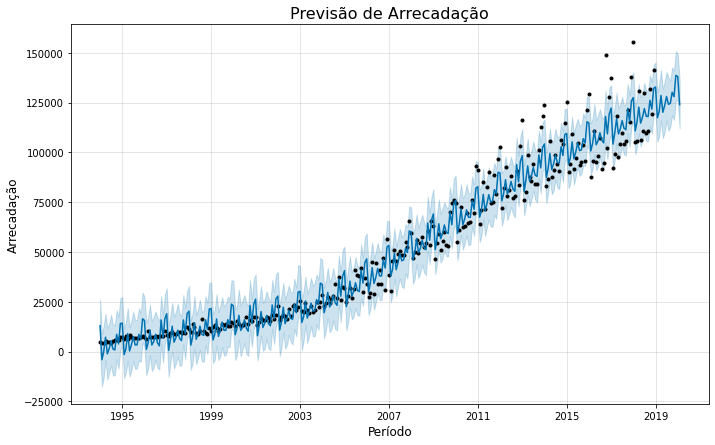

In [ ]:
#Cria datas futuras e faz a predição
prophet_forecast = prophet_model.make_future_dataframe(periods=14, freq='MS')
prophet_forecast = prophet_model.predict(prophet_forecast)

#Plotagem do gráfico de previsão
fig = prophet_model.plot(prophet_forecast)
ax1 = fig.gca()
ax1.set_title("Previsão de Arrecadação", fontsize=16)
ax1.set_xlabel("Período", fontsize=12)
ax1.set_ylabel("Arrecadação", fontsize=12)

In [ ]:
#Seleciona os dados previstos apenas para o período de teste
prophet_forecast = prophet_forecast[prophet_forecast['ds'] > '2018-12-01']
prophet_forecast.head()

ds          trend  ...  multiplicative_terms_upper           yhat
300 2019-01-01  124356.240643  ...                         0.0  132835.088516
301 2019-02-01  124850.303486  ...                         0.0  117395.338242
302 2019-03-01  125296.553796  ...                         0.0  120361.823119
303 2019-04-01  125790.616638  ...                         0.0  128578.085779
304 2019-05-01  126268.741970  ...                         0.0  120152.928112
305 2019-06-01  126762.804813  ...                         0.0  123669.021680
306 2019-07-01  127240.930144  ...                         0.0  128052.490465
307 2019-08-01  127734.992987  ...                         0.0  124190.784839
308 2019-09-01  128229.055830  ...                         0.0  124583.851815
309 2019-10-01  128707.181161  ...                         0.0  130186.307804
310 2019-11-01  129201.244004  ...                         0.0  127972.033460
311 2019-12-01  129679.369336  ...                         0.0  138680.233078
312 2020-01-01  130173.432178  ...                         0.0  138119.883251
313 2020-02-01  130667.495021  ...                         0.0  124004.528851

[14 rows x 16 columns]

In [ ]:
#Escolhe as datas ('ds' e 'ds_test') como índices
prophet_forecast.set_index(prophet_forecast['ds'], inplace=True) 
dfarrec_test_prophet.set_index(dfarrec_test_prophet['ds_test'], inplace=True) 
dfarrec_train_prophet.set_index(dfarrec_train_prophet['ds'], inplace=True) 

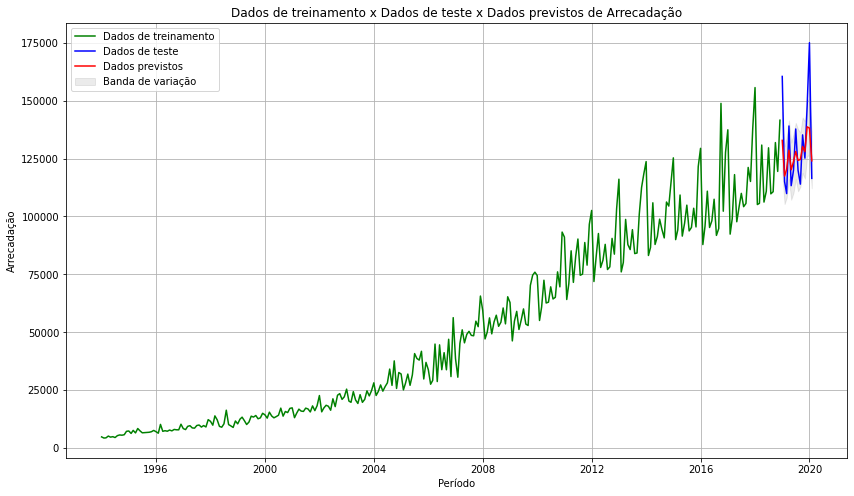

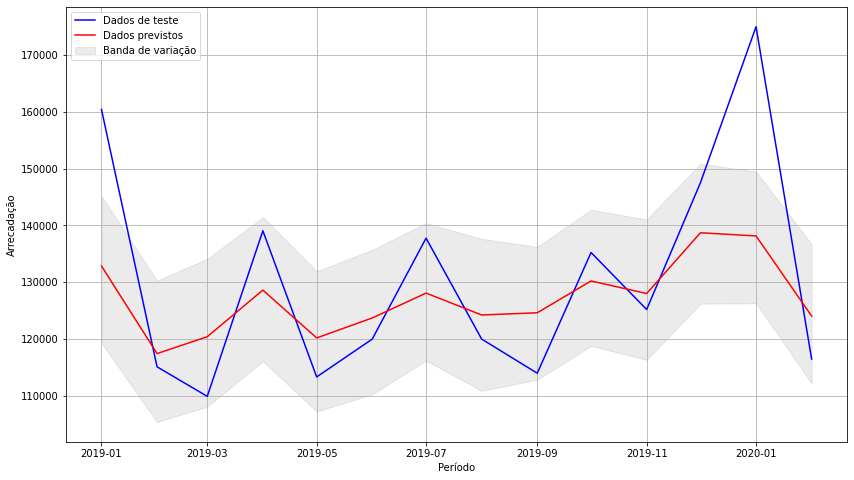

In [ ]:
#Plotagem do comparativo entre o preço previsto e o dataset
n = dfarrec_train_prophet.shape[0]
plt.figure(figsize=(14,8))
plt.title('Dados de treinamento x Dados de teste x Dados previstos de Arrecadação')
plt.plot(dfarrec_train_prophet['y'], 'green', label='Dados de treinamento')
plt.plot(dfarrec_test_prophet['y_test'], color = 'blue', label='Dados de teste')
plt.plot(prophet_forecast['yhat'][-n:], color = 'red', label = 'Dados previstos')
plt.fill_between(prophet_forecast.index[-n:], prophet_forecast['yhat_lower'][-n:], prophet_forecast['yhat_upper'][-n:], color='k', alpha=.08, label="Banda de variação")
plt.xlabel("Período")
plt.ylabel("Arrecadação")
plt.legend()
#plt.savefig('prophet1.pdf')
plt.grid(True)

#Plotagem do comparativo entre o preço previsto e o preço de validação
plt.figure(figsize=(14,8))
plt.plot(dfarrec_test_prophet['y_test'], color = 'blue', label='Dados de teste')
plt.plot(prophet_forecast['yhat'], color = 'red', label = 'Dados previstos')
plt.fill_between(prophet_forecast.index[-n:], prophet_forecast['yhat_lower'][-n:], prophet_forecast['yhat_upper'][-n:], color='k', alpha=.08, label="Banda de variação")
plt.xlabel("Período")
plt.ylabel("Arrecadação")
plt.legend()
plt.grid(True)
#plt.savefig('prophet2.pdf')
plt.show()

In [ ]:
#Cálculo do erro
print('MAE: ', mean_absolute_error(dfarrec_test_prophet['y_test'],prophet_forecast['yhat']))
print('MSE: ', mean_squared_error(dfarrec_test_prophet['y_test'],prophet_forecast['yhat']))
print('RMSE: ', np.sqrt(mean_squared_error(dfarrec_test_prophet['y_test'],prophet_forecast['yhat'])))

MAE:  10510.587230358593
MSE:  200026457.37499568
RMSE:  14143.07100226099


## Comparativo entre os modelos

In [ ]:
rmse_errors = [arima_rmse_error, lstm_rmse_error, prophet_rmse_error]
mse_errors = [arima_mse_error, lstm_mse_error, prophet_mse_error]
errors = pd.DataFrame({"Models" : ["ARIMA", "LSTM", "Prophet"],"RMSE Errors" : rmse_errors, "MSE Errors" : mse_errors})

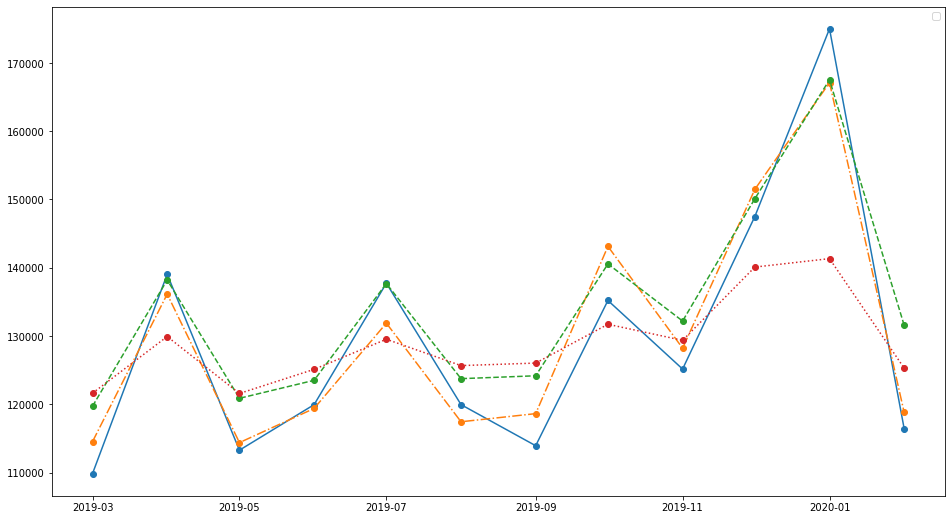

In [ ]:
plt.figure(figsize=(16,9))
plt.plot_date(test_data.index, test_data["y"], linestyle="-")
plt.plot_date(test_data.index, test_data["ARIMA_Predictions"], linestyle="-.")
plt.plot_date(test_data.index, test_data["LSTM_Predictions"], linestyle="--")
plt.plot_date(test_data.index, test_data["Prophet_Predictions"], linestyle=":")
plt.legend()
plt.show()

In [ ]:
print(f"Mean: {test_data['y'].mean()}")
errors

Mean: 129417.66666666667


Models   RMSE Errors    MSE Errors
0    ARIMA   4567.200703  2.085932e+07
1     LSTM   7404.772293  5.483065e+07
2  Prophet  12449.931929  1.550008e+08

In [ ]:
test_data

y  ARIMA_Predictions  LSTM_Predictions  Prophet_Predictions
ds                                                                          
2019-03-01  109854      114538.221536     119725.200061        121630.326801
2019-04-01  139030      136135.889426     138206.986727        129922.933794
2019-05-01  113278      114385.365859     120876.386910        121583.844712
2019-06-01  119946      119389.395546     123511.827040        125117.610239
2019-07-01  137735      131883.349396     137679.333062        129526.413885
2019-08-01  119951      117439.879777     123752.316615        125666.318949
2019-09-01  113933      118629.422669     124174.257203        126033.950733
2019-10-01  135202      143127.237904     140554.220802        131719.143913
2019-11-01  125161      128216.866629     132194.375215        129363.723922
2019-12-01  147501      151476.405793     150109.127467        140094.810948
2020-01-01  174991      167102.885630     167520.991363        141330.877965
2020-02-01  116430      118813.306616     131574.135389        125291.666429

## **MODELOS PREDITIVOS DO PIB**







## Modelo preditivo ARIMA

In [9]:
# Definição do conjunto de treinamento e do conjunto de teste
dfpib_train_arima = dfpib.iloc[:-14].copy()  
dfpib_test_arima =  dfpib.iloc[-14:].copy()

In [12]:
# Utilização do auto-arima para identificar o melhor modelo de forma automática
model = auto_arima(dfpib_train_arima['pib'], start_p=1, start_q=1, max_p=3, max_q=3, d=1, stationary = False, start_P=0, D=1, trace=True,
                   error_action='ignore', suppress_warnings=True, stepwise=True, seasonal= True, m=12)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=5853.507, Time=0.69 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5964.730, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5903.095, Time=0.32 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5853.724, Time=0.34 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=5908.871, Time=0.19 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=5853.158, Time=0.76 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=5879.080, Time=0.54 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=5842.195, Time=4.78 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=5862.758, Time=1.31 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=5855.201, Time=3.63 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=5853.204, Time=2.55 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=5852.778, Time=1.45 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=5873.957, Time=1.43 sec
 ARIMA(2,1,1)(2,1,1)[12]             : AIC=5853.135, Time=4.68 sec
 ARIMA(1,1,2)(2,1,1

In [13]:
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  300
Model:             SARIMAX(1, 1, 1)x(2, 1, 1, 12)   Log Likelihood               -2915.098
Date:                            Fri, 12 Feb 2021   AIC                           5842.195
Time:                                    19:37:14   BIC                           5864.152
Sample:                                         0   HQIC                          5850.995
                                            - 300                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1355      0.089      1.520      0.129      -0.039       0.310
ma.L1         -0.6300      0.076   

In [14]:
# Treinamento do modelo
model.fit(dfpib_train_arima['pib'])

ARIMA(maxiter=50, method='lbfgs', order=(1, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(2, 1, 1, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [15]:
#Faz a predição 
forecast_arima = model.predict(n_periods=len(dfpib_test_arima['pib']))
forecast_arima = pd.DataFrame(forecast_arima, index = dfpib_test_arima.index,columns=['Prediction'])
conf_int = model.predict(len(dfpib_test_arima['pib']), return_conf_int=True, alpha = 0.05) #Pega o intervalo de confiança

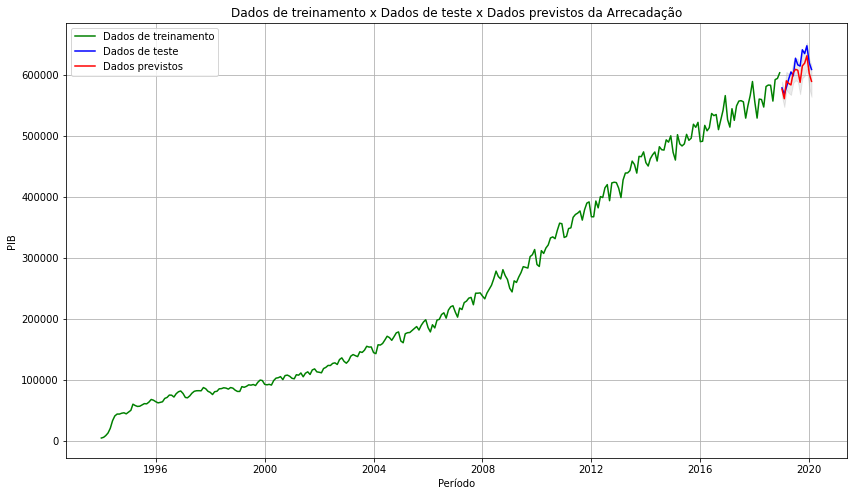

In [16]:
#Plotagem dos dados de treinamento, teste e previsão
plt.figure(figsize=(14,8))
plt.title('Dados de treinamento x Dados de teste x Dados previstos do PIB')
plt.plot(dfpib_train_arima['pib'], color='green', label = 'Dados de treinamento')
plt.plot(dfpib_test_arima['pib'], color = 'blue', label = 'Dados de teste')
plt.fill_between(dfpib_test_arima.index, conf_int[1][:,0], conf_int[1][:,1], 
                 color='k', alpha=.08)
plt.plot(forecast_arima['Prediction'], color = 'red', label = 'Dados previstos')
plt.xlabel('Período')
plt.ylabel('PIB')
plt.legend()
plt.grid(True)
#plt.savefig('arima1.pdf')
plt.show()

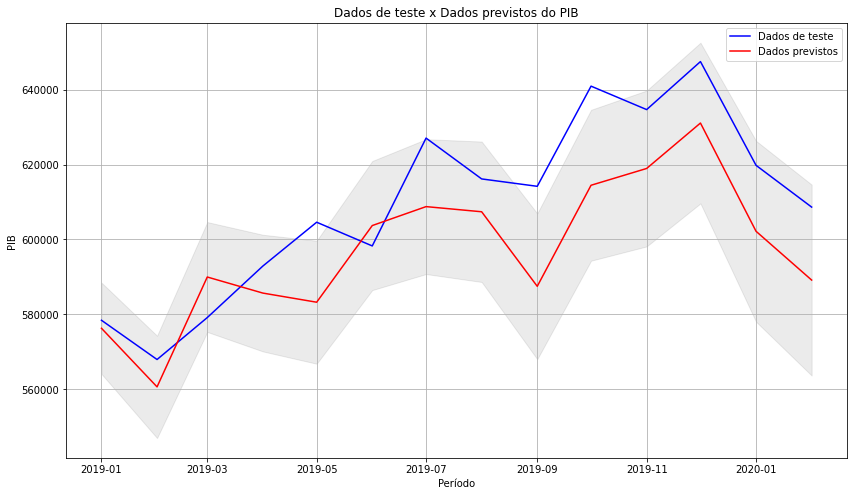

In [17]:
#Plotagem dos dados de teste e previsão
plt.figure(figsize=(14,8))
plt.title('Dados de teste x Dados previstos do PIB')
plt.plot(dfpib_test_arima['pib'], color = 'blue', label = 'Dados de teste')
plt.fill_between(dfpib_test_arima.index, conf_int[1][:,0], conf_int[1][:,1], 
                 color='k', alpha=.08)
plt.plot(forecast_arima['Prediction'], color = 'red', label = 'Dados previstos')
plt.xlabel('Período')
plt.ylabel('PIB')
plt.legend()
plt.grid(True)
#plt.savefig('arima2.pdf')
plt.show()

In [18]:
#Cálculo do erro
mse = mean_squared_error(dfpib_test_arima['pib'], forecast_arima['Prediction'])
print('MSE: '+str(mse))
mae = mean_absolute_error(dfpib_test_arima['pib'], forecast_arima['Prediction'])
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(dfpib_test_arima['pib'], forecast_arima['Prediction']))
print('RMSE: '+str(rmse))

MSE: 266946130.59801453
MAE: 14539.621477775616
RMSE: 16338.486178285139


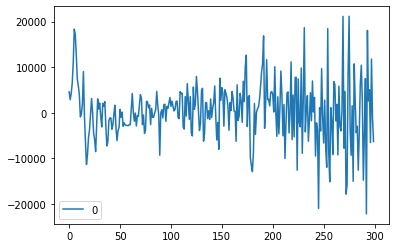

In [19]:
#Plotagem dos resíduos
residuals = pd.DataFrame(model.resid())
residuals.plot()

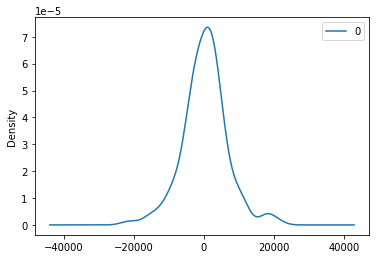

                  0
count    300.000000
mean     327.237730
std     6388.970284
min   -22247.208611
25%    -3042.170693
50%      499.086663
75%     3602.002112
max    21186.404635


In [20]:
#Plotagem da densidade dos resíduos
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [ ]:
test_data['ARIMA_Predictions'] = arima_pred

## Modelo Preditivo LSTM

First we'll scale our train and test data with MinMaxScaler

In [ ]:
# Definição do conjunto de treinamento e do conjunto de teste
dfarrec_train_lstm = dfarrec.iloc[:-14].copy()  
dfarrec_test_lstm =  dfarrec.iloc[-14:].copy()

In [ ]:
#Normalização dos dados
train_lstm = dfarrec_train_lstm.iloc[:,0:1].values
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_scaled_lstm = scaler.fit_transform(train_lstm) 
train_scaled_lstm

array([[3.25894392e-03],
       [0.00000000e+00],
       [4.95782543e-04],
       [5.57259579e-03],
       [2.57145879e-03],
       [3.88032470e-03],
       [1.36174939e-03],
       [6.82196779e-03],
       [8.78526666e-03],
       [8.08456067e-03],
       [9.41325789e-03],
       [1.91768688e-02],
       [2.01221608e-02],
       [1.31481530e-02],
       [2.18342632e-02],
       [1.46090589e-02],
       [2.71622729e-02],
       [2.03997990e-02],
       [1.49197493e-02],
       [1.54816362e-02],
       [1.60567440e-02],
       [1.64401491e-02],
       [1.80663159e-02],
       [2.17152754e-02],
       [1.80927576e-02],
       [1.37827547e-02],
       [3.89024036e-02],
       [1.91702583e-02],
       [2.08955816e-02],
       [1.94412861e-02],
       [2.27861657e-02],
       [2.04460721e-02],
       [2.44982681e-02],
       [2.35133134e-02],
       [2.34207673e-02],
       [3.94047965e-02],
       [2.68581930e-02],
       [2.41346942e-02],
       [3.33430286e-02],
       [3.52005606e-02],


In [ ]:
#Criação de uma estrutura de dados com 60 timesteps e 1 saída que neste caso será o preço de fechamento da ação
timesteps = 60
x_train_lstm = []
y_train_lstm = []
for i in range(timesteps, train_lstm.shape[0]):
    x_train_lstm.append(train_scaled_lstm[i-timesteps:i, 0]) #Utilização de 60 timesteps anteriores
    y_train_lstm.append(train_scaled_lstm[i, 0]) #O 120º preço de fechamento será o valor de y
x_train_lstm, y_train_lstm = np.array(x_train_lstm), np.array(y_train_lstm)

In [ ]:
x_train_lstm = np.reshape(x_train_lstm, (x_train_lstm.shape[0], x_train_lstm.shape[1], 1))

In [ ]:
#Criação da LSTM utilizando a biblioteca Keras

#seed=2016
#np.random.seed (seed)

# Inicialização da RNN
model_rnn = Sequential()

#O parâmetro return_sequences=True indica que a rede terá mais camadas a frente
#O parâmetro Dropout ajuda no ajuste do Overfitting

# Adiciona a primeira camada LSTM com o Dropout 
model_rnn.add(LSTM(units = 128, return_sequences = True, input_shape = (x_train_lstm.shape[1], 1)))
model_rnn.add(Dropout(0.3))

# Adiciona a segunda camada LSTM com o Dropout
model_rnn.add(LSTM(units = 64))
model_rnn.add(Dropout(0.3))

# Adiciona a camada de saída 
#model_rnn.add(Dense(16,init='uniform',activation='relu'))
model_rnn.add(Dense(1,activation='linear'))

# Compila a RNN, neste caso utilizando o otimizador 'Adam'
model_rnn.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mean_absolute_error'])

# Faz o treinamento da RNN utilizando o dataset de treinamento
model_rnn.fit(x_train_lstm, y_train_lstm, epochs = 100, batch_size = 32) 

#Mostra o resumo do modelo
model_rnn.summary()

Epoch 1/100
8/8 [==============================] - 4s 83ms/step - loss: 0.1093 - mean_absolute_error: 0.2504
Epoch 2/100
8/8 [==============================] - 1s 83ms/step - loss: 0.0145 - mean_absolute_error: 0.0867
Epoch 3/100
8/8 [==============================] - 1s 82ms/step - loss: 0.0089 - mean_absolute_error: 0.0735
Epoch 4/100
8/8 [==============================] - 1s 82ms/step - loss: 0.0095 - mean_absolute_error: 0.0723
Epoch 5/100
8/8 [==============================] - 1s 83ms/step - loss: 0.0071 - mean_absolute_error: 0.0575
Epoch 6/100
8/8 [==============================] - 1s 81ms/step - loss: 0.0050 - mean_absolute_error: 0.0490
Epoch 7/100
8/8 [==============================] - 1s 84ms/step - loss: 0.0072 - mean_absolute_error: 0.0574
Epoch 8/100
8/8 [==============================] - 1s 78ms/step - loss: 0.0048 - mean_absolute_error: 0.0486
Epoch 9/100
8/8 [==============================] - 1s 81ms/step - loss: 0.0064 - mean_absolute_error: 0.0545
Epoch 10/100
8/8 [=

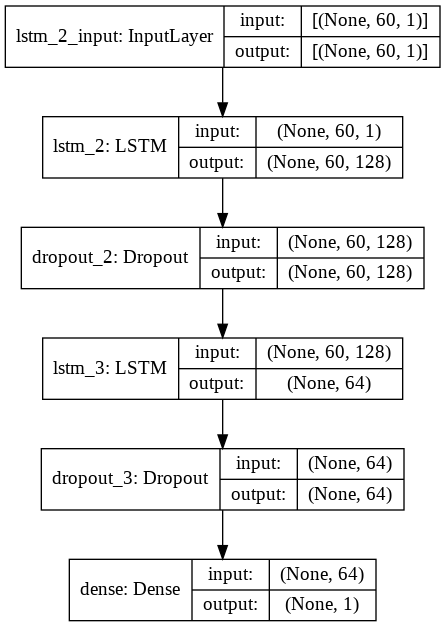

In [ ]:
#Visualização do modelo
plot_model(model_rnn, show_shapes=True) #Acrescente o parâmetro 'to_file='model_rnn.png' para exportar a figura

In [ ]:
#Carregamentos dos dados de teste para fazer as predições
test_lstm = dfarrec_test_lstm.iloc[:,0:1].values

In [ ]:
# Concatena os dados de treinamento e teste, pois os preços de fechamento anteriores não estão no conjunto de teste
combine = pd.concat((dfarrec_train_lstm['arrec'], dfarrec_test_lstm['arrec']), axis = 0)

# Tratamento do conjunto de teste considerando os timesteps anteriores
test_inputs = combine[len(combine) - len(dfarrec_test_lstm) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)

# Normalização dos dados
test_inputs = scaler.transform(test_inputs)

In [ ]:
# Predição utilizando os dados de teste
x_test_lstm = []
for i in range(timesteps, dfarrec_test_lstm.shape[0]+timesteps):
    x_test_lstm.append(test_inputs[i-timesteps:i, 0])
x_test_lstm = np.array(x_test_lstm)
x_test_lstm = np.reshape(x_test_lstm, (x_test_lstm.shape[0], x_test_lstm.shape[1], 1))
predictions_lstm = model_rnn.predict(x_test_lstm)

# Desnormaliza os dados
predictions_lstm = scaler.inverse_transform(predictions_lstm)

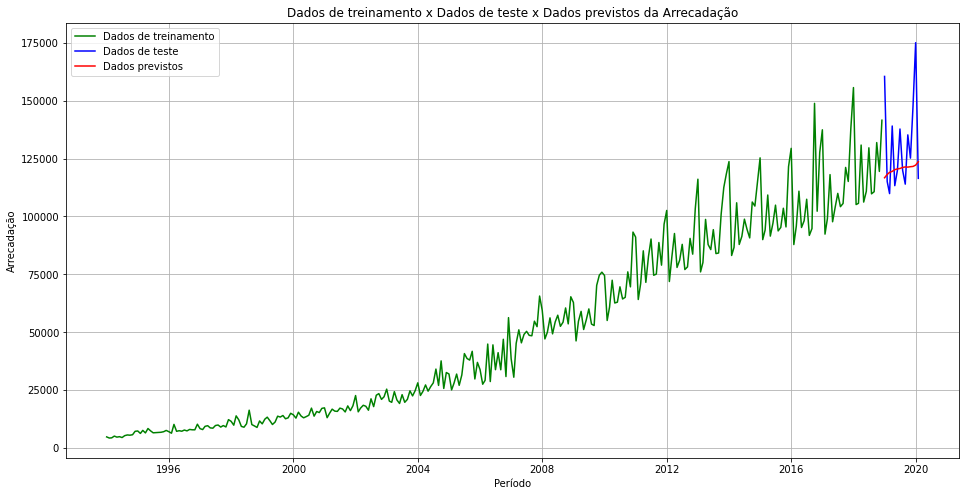

In [ ]:
#Plotagem dos dados de treinamento, teste e previsão
plt.figure(figsize=(16,8))
plt.plot(dfarrec_train_lstm.index, dfarrec_train_lstm, color='green', label = 'Dados de treinamento')
plt.plot(dfarrec_test_lstm.index, dfarrec_test_lstm, color = 'blue', label = 'Dados de teste')
plt.plot(dfarrec_test_lstm.index, predictions_lstm, color = 'red', label = 'Dados previstos')
plt.title('Dados de treinamento x Dados de teste x Dados previstos da Arrecadação')
plt.xlabel('Período')
plt.ylabel('Arrecadação')
plt.legend()
plt.grid(True)
#plt.savefig('lstm1.pdf')
plt.show()

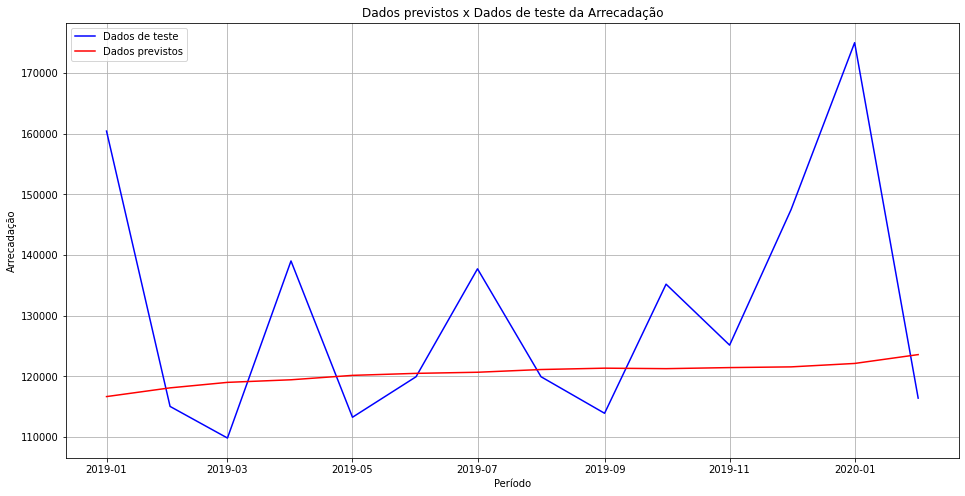

In [ ]:
#Plotagem dos dados de teste e dados previstos
plt.figure(figsize=(16,8))
plt.plot(dfarrec_test_lstm.index, test_lstm, color = 'blue', label = 'Dados de teste')
plt.plot(dfarrec_test_lstm.index, predictions_lstm, color = 'red', label = 'Dados previstos')
plt.title('Dados previstos x Dados de teste da Arrecadação')
plt.xlabel('Período')
plt.ylabel('Arrecadação')
plt.legend()
plt.grid(True)
#plt.savefig('lstm2.pdf')
plt.show()

In [ ]:
#Cálculo do erro
print('MAE: ', mean_absolute_error(dfarrec_test_lstm,predictions_lstm))
print('MSE: ', mean_squared_error(dfarrec_test_lstm,predictions_lstm))
print('RMSE: ', np.sqrt(mean_squared_error(dfarrec_test_lstm,predictions_lstm)))

MAE:  15159.853794642857
MSE:  464928611.8123169
RMSE:  21562.203315345974


In [ ]:
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

Before creating LSTM model we should create a Time Series Generator object.

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               161600    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm_model.fit_generator(generator,epochs=20)

Epoch 1/20
290/290 [==============================] - 4s 10ms/step - loss: 0.0269
Epoch 2/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0047
Epoch 3/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0073
Epoch 4/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0043
Epoch 5/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0052
Epoch 6/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0043
Epoch 7/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0039
Epoch 8/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0046
Epoch 9/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0050
Epoch 10/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0029
Epoch 11/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0020
Epoch 12/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0029
Epoch 13/20
2

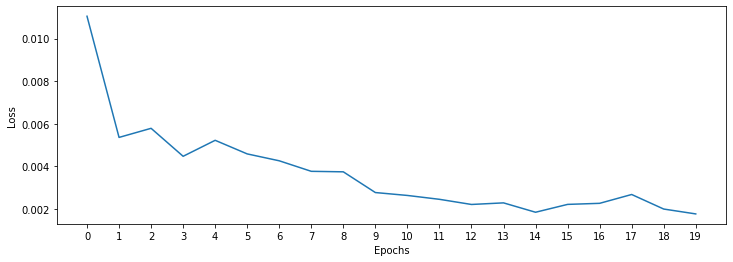

In [ ]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [ ]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

As you know we scaled our data that's why we have to inverse it to see true predictions.

In [ ]:
lstm_predictions_scaled

[array([0.7392362], dtype=float32),
 array([0.85764617], dtype=float32),
 array([0.74661165], dtype=float32),
 array([0.7634965], dtype=float32),
 array([0.8542656], dtype=float32),
 array([0.7650373], dtype=float32),
 array([0.7677406], dtype=float32),
 array([0.87268454], dtype=float32),
 array([0.8191243], dtype=float32),
 array([0.93390137], dtype=float32),
 array([1.0454565], dtype=float32),
 array([0.8151505], dtype=float32)]

In [ ]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [ ]:
lstm_predictions

array([[119725.20006078],
       [138206.9867273 ],
       [120876.38690966],
       [123511.82704008],
       [137679.33306229],
       [123752.31661534],
       [124174.25720322],
       [140554.22080153],
       [132194.37521476],
       [150109.12746686],
       [167520.99136341],
       [131574.13538909]])

In [ ]:
test_data['LSTM_Predictions'] = lstm_predictions

In [ ]:
test_data

y  ARIMA_Predictions  LSTM_Predictions
ds                                                     
2019-03-01  109854      114538.221536     119725.200061
2019-04-01  139030      136135.889426     138206.986727
2019-05-01  113278      114385.365859     120876.386910
2019-06-01  119946      119389.395546     123511.827040
2019-07-01  137735      131883.349396     137679.333062
2019-08-01  119951      117439.879777     123752.316615
2019-09-01  113933      118629.422669     124174.257203
2019-10-01  135202      143127.237904     140554.220802
2019-11-01  125161      128216.866629     132194.375215
2019-12-01  147501      151476.405793     150109.127467
2020-01-01  174991      167102.885630     167520.991363
2020-02-01  116430      118813.306616     131574.135389

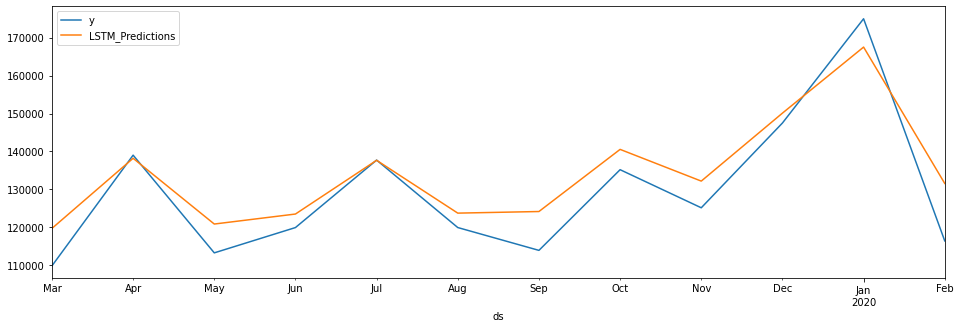

In [ ]:
test_data['y'].plot(figsize = (16,5), legend=True)
test_data['LSTM_Predictions'].plot(legend = True);

In [ ]:
lstm_rmse_error = rmse(test_data['y'], test_data["LSTM_Predictions"])
lstm_mse_error = lstm_rmse_error**2
mean_value = df['y'].mean()

print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMean: {mean_value}')

MSE Error: 54830652.711122535
RMSE Error: 7404.772292996087
Mean: 54008.87898089172


## Modelo Preditivo PROPHET

In [21]:
# Definição do conjunto de treinamento e do conjunto de teste
dfpib_train_prophet = dfpib.iloc[:-14].copy()  
dfpib_test_prophet =  dfpib.iloc[-14:].copy()

In [22]:
#Renomeia as colunas 'arrec' para 'y' e 'Data' para 'ds' do conjunto de treinamento e teste
dfpib_train_prophet = pd.DataFrame({"ds": dfpib_train_prophet.index, "y": dfpib_train_prophet.pib})
dfpib_train_prophet.reset_index(drop = True, inplace = True)
dfpib_test_prophet = pd.DataFrame({"ds_test": dfpib_test_prophet.index, "y_test": dfpib_test_prophet.pib})
dfpib_test_prophet.reset_index(drop = True, inplace = True)

In [23]:
dfpib_train_prophet.head()

ds      y
0 1994-01-01   4563
1 1994-02-01   5793
2 1994-03-01   8520
3 1994-04-01  12829
4 1994-05-01  20504

In [24]:
dfpib_test_prophet.head(30)

ds_test  y_test
0  2019-01-01  578453
1  2019-02-01  567985
2  2019-03-01  579173
3  2019-04-01  592916
4  2019-05-01  604607
5  2019-06-01  598283
6  2019-07-01  627050
7  2019-08-01  616158
8  2019-09-01  614188
9  2019-10-01  640907
10 2019-11-01  634654
11 2019-12-01  647460
12 2020-01-01  619785
13 2020-02-01  608644

In [25]:
#Utiliza a biblioteca Prophet para fazer a previsão
prophet_model = Prophet(changepoint_prior_scale=0.05, interval_width=0.95, daily_seasonality=False)
prophet_model.fit(dfpib_train_prophet)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Text(41.375, 0.5, 'PIB')

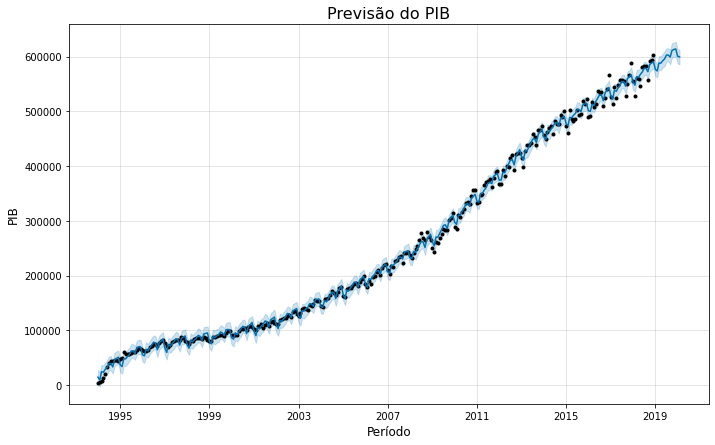

In [26]:
#Cria datas futuras e faz a predição
prophet_forecast = prophet_model.make_future_dataframe(periods=14, freq='MS')
prophet_forecast = prophet_model.predict(prophet_forecast)

#Plotagem do gráfico de previsão
fig = prophet_model.plot(prophet_forecast)
ax1 = fig.gca()
ax1.set_title("Previsão do PIB", fontsize=16)
ax1.set_xlabel("Período", fontsize=12)
ax1.set_ylabel("PIB", fontsize=12)

In [27]:
#Seleciona os dados previstos apenas para o período de teste
prophet_forecast = prophet_forecast[prophet_forecast['ds'] > '2018-12-01']
prophet_forecast.head()

ds          trend  ...  multiplicative_terms_upper           yhat
300 2019-01-01  585628.418285  ...                         0.0  576772.797418
301 2019-02-01  587739.767215  ...                         0.0  573636.669971
302 2019-03-01  589646.792055  ...                         0.0  588290.875358
303 2019-04-01  591758.140985  ...                         0.0  587888.265874
304 2019-05-01  593801.381886  ...                         0.0  592300.805411

[5 rows x 16 columns]

In [28]:
#Escolhe as datas ('ds' e 'ds_test') como índices
prophet_forecast.set_index(prophet_forecast['ds'], inplace=True) 
dfpib_test_prophet.set_index(dfpib_test_prophet['ds_test'], inplace=True) 
dfpib_train_prophet.set_index(dfpib_train_prophet['ds'], inplace=True) 

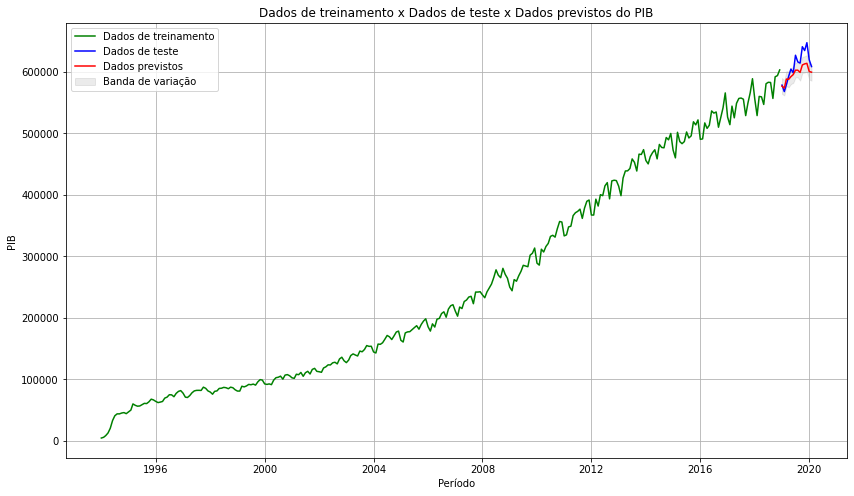

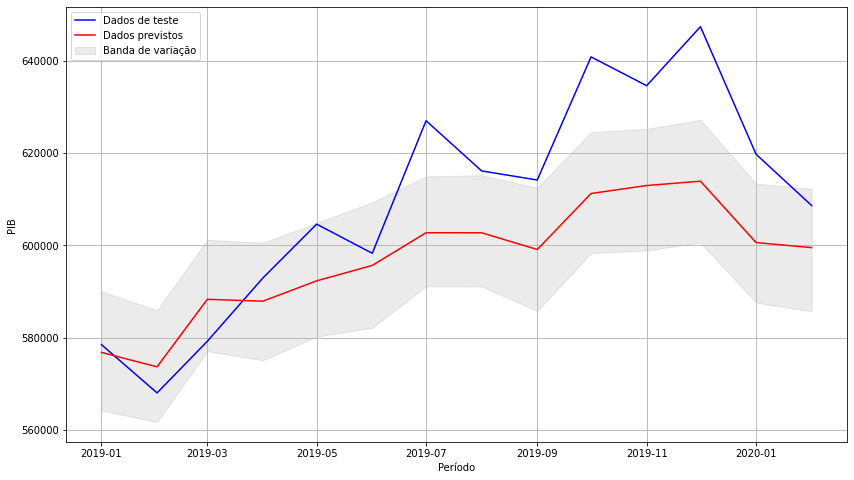

In [29]:
#Plotagem do comparativo entre o preço previsto e o dataset
n = dfpib_train_prophet.shape[0]
plt.figure(figsize=(14,8))
plt.title('Dados de treinamento x Dados de teste x Dados previstos do PIB')
plt.plot(dfpib_train_prophet['y'], 'green', label='Dados de treinamento')
plt.plot(dfpib_test_prophet['y_test'], color = 'blue', label='Dados de teste')
plt.plot(prophet_forecast['yhat'][-n:], color = 'red', label = 'Dados previstos')
plt.fill_between(prophet_forecast.index[-n:], prophet_forecast['yhat_lower'][-n:], prophet_forecast['yhat_upper'][-n:], color='k', alpha=.08, label="Banda de variação")
plt.xlabel("Período")
plt.ylabel("PIB")
plt.legend()
#plt.savefig('prophet1.pdf')
plt.grid(True)

#Plotagem do comparativo entre o preço previsto e o preço de validação
plt.figure(figsize=(14,8))
plt.plot(dfpib_test_prophet['y_test'], color = 'blue', label='Dados de teste')
plt.plot(prophet_forecast['yhat'], color = 'red', label = 'Dados previstos')
plt.fill_between(prophet_forecast.index[-n:], prophet_forecast['yhat_lower'][-n:], prophet_forecast['yhat_upper'][-n:], color='k', alpha=.08, label="Banda de variação")
plt.xlabel("Período")
plt.ylabel("PIB")
plt.legend()
plt.grid(True)
#plt.savefig('prophet2.pdf')
plt.show()

In [30]:
#Cálculo do erro
print('MAE: ', mean_absolute_error(dfpib_test_prophet['y_test'],prophet_forecast['yhat']))
print('MSE: ', mean_squared_error(dfpib_test_prophet['y_test'],prophet_forecast['yhat']))
print('RMSE: ', np.sqrt(mean_squared_error(dfpib_test_prophet['y_test'],prophet_forecast['yhat'])))

MAE:  14456.372713588835
MSE:  301714278.29169077
RMSE:  17369.924533275633


## Comparativo entre os modelos

In [ ]:
rmse_errors = [arima_rmse_error, lstm_rmse_error, prophet_rmse_error]
mse_errors = [arima_mse_error, lstm_mse_error, prophet_mse_error]
errors = pd.DataFrame({"Models" : ["ARIMA", "LSTM", "Prophet"],"RMSE Errors" : rmse_errors, "MSE Errors" : mse_errors})

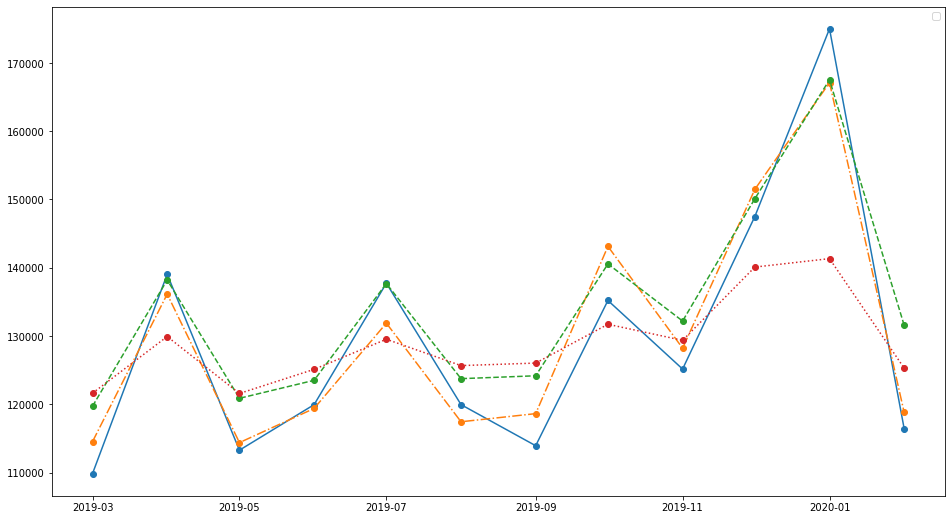

In [ ]:
plt.figure(figsize=(16,9))
plt.plot_date(test_data.index, test_data["y"], linestyle="-")
plt.plot_date(test_data.index, test_data["ARIMA_Predictions"], linestyle="-.")
plt.plot_date(test_data.index, test_data["LSTM_Predictions"], linestyle="--")
plt.plot_date(test_data.index, test_data["Prophet_Predictions"], linestyle=":")
plt.legend()
plt.show()

In [ ]:
print(f"Mean: {test_data['y'].mean()}")
errors

Mean: 129417.66666666667


Models   RMSE Errors    MSE Errors
0    ARIMA   4567.200703  2.085932e+07
1     LSTM   7404.772293  5.483065e+07
2  Prophet  12449.931929  1.550008e+08

In [ ]:
test_data

y  ARIMA_Predictions  LSTM_Predictions  Prophet_Predictions
ds                                                                          
2019-03-01  109854      114538.221536     119725.200061        121630.326801
2019-04-01  139030      136135.889426     138206.986727        129922.933794
2019-05-01  113278      114385.365859     120876.386910        121583.844712
2019-06-01  119946      119389.395546     123511.827040        125117.610239
2019-07-01  137735      131883.349396     137679.333062        129526.413885
2019-08-01  119951      117439.879777     123752.316615        125666.318949
2019-09-01  113933      118629.422669     124174.257203        126033.950733
2019-10-01  135202      143127.237904     140554.220802        131719.143913
2019-11-01  125161      128216.866629     132194.375215        129363.723922
2019-12-01  147501      151476.405793     150109.127467        140094.810948
2020-01-01  174991      167102.885630     167520.991363        141330.877965
2020-02-01  116430      118813.306616     131574.135389        125291.666429

## **MODELOS PREDITIVOS DA ARRECADAÇÃO FEDERAL**

## Modelo preditivo ARIMA

In [ ]:
# Definição do conjunto de treinamento e do conjunto de teste
dfarrec_train_arima = dfarrec.iloc[:-14].copy()  
dfarrec_test_arima =  dfarrec.iloc[-14:].copy()

In [ ]:
# Utilização do auto-arima para identificar o melhor modelo de forma automática
model = auto_arima(dfarrec_train_arima['arrec'], start_p=1, start_q=1, max_p=3, max_q=3, d=1, stationary = False, start_P=0, D=1, trace=True,
                   error_action='ignore', suppress_warnings=True, stepwise=True, seasonal= True, m=12)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=5700.993, Time=1.27 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5922.820, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5785.124, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5699.424, Time=0.98 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=5781.815, Time=0.12 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=5699.614, Time=1.34 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=5718.844, Time=0.91 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=5720.122, Time=0.81 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=5692.038, Time=5.42 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=inf, Time=7.10 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=5719.306, Time=1.11 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=5852.188, Time=1.73 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=5694.244, Time=7.47 sec
 ARIMA(0,1,2)(1,1,2)[12]             : AIC=inf, Time=6.06 sec
 ARIMA(1,1,0)(1,1,2)[12]     

In [ ]:
print(model.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  300
Model:             SARIMAX(0, 1, 1)x(1, 1, [1, 2], 12)   Log Likelihood               -2841.019
Date:                                 Wed, 10 Feb 2021   AIC                           5692.038
Time:                                         18:51:06   BIC                           5710.336
Sample:                                              0   HQIC                          5699.372
                                                 - 300                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8176      0.030    -27.451      0.000      -0.876      -0

As we can see best arima model chosen by auto_arima() is SARIMAX(2, 1, 1)x(4, 0, 3, 12)

Let's split the data into train and test set

In [ ]:
# Treinamento do modelo
model.fit(dfarrec_train_arima['arrec'])

ARIMA(maxiter=50, method='lbfgs', order=(0, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(1, 1, 2, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [ ]:
#Faz a predição 
forecast_arima = model.predict(n_periods=len(dfarrec_test_arima['arrec']))
forecast_arima = pd.DataFrame(forecast_arima, index = dfarrec_test_arima.index,columns=['Prediction'])
conf_int = model.predict(len(dfarrec_test_arima['arrec']), return_conf_int=True, alpha = 0.05) #Pega o intervalo de confiança

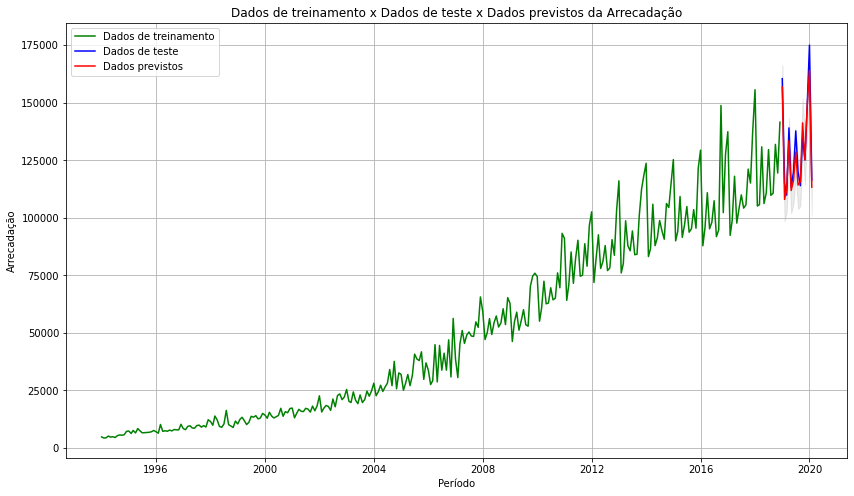

In [ ]:
#Plotagem dos dados de treinamento, teste e previsão
plt.figure(figsize=(14,8))
plt.title('Dados de treinamento x Dados de teste x Dados previstos da Arrecadação')
plt.plot(dfarrec_train_arima['arrec'], color='green', label = 'Dados de treinamento')
plt.plot(dfarrec_test_arima['arrec'], color = 'blue', label = 'Dados de teste')
plt.fill_between(dfarrec_test_arima.index, conf_int[1][:,0], conf_int[1][:,1], 
                 color='k', alpha=.08)
plt.plot(forecast_arima['Prediction'], color = 'red', label = 'Dados previstos')
plt.xlabel('Período')
plt.ylabel('Arrecadação')
plt.legend()
plt.grid(True)
#plt.savefig('arima1.pdf')
plt.show()

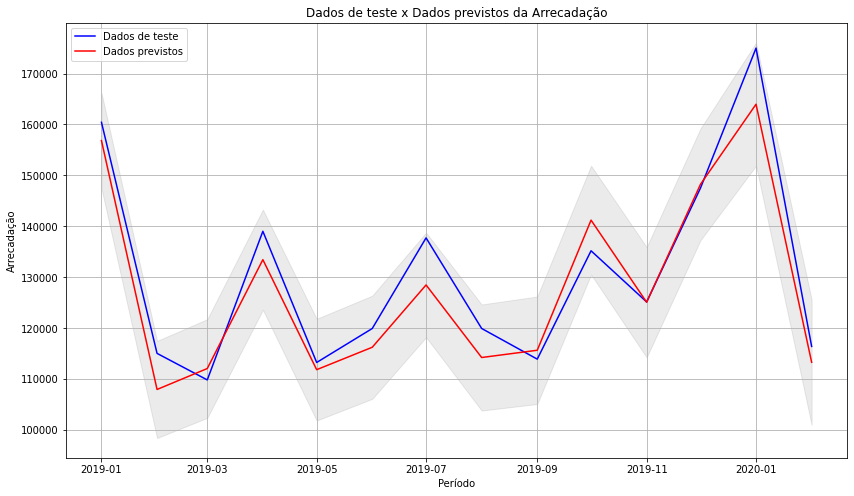

In [ ]:
#Plotagem dos dados de teste e previsão
plt.figure(figsize=(14,8))
plt.title('Dados de teste x Dados previstos da Arrecadação')
plt.plot(dfarrec_test_arima['arrec'], color = 'blue', label = 'Dados de teste')
plt.fill_between(dfarrec_test_arima.index, conf_int[1][:,0], conf_int[1][:,1], 
                 color='k', alpha=.08)
plt.plot(forecast_arima['Prediction'], color = 'red', label = 'Dados previstos')
plt.xlabel('Período')
plt.ylabel('Arrecadação')
plt.legend()
plt.grid(True)
#plt.savefig('arima2.pdf')
plt.show()

In [ ]:
#Cálculo do erro
mse = mean_squared_error(dfarrec_test_arima['arrec'], forecast_arima['Prediction'])
print('MSE: '+str(mse))
mae = mean_absolute_error(dfarrec_test_arima['arrec'], forecast_arima['Prediction'])
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(dfarrec_test_arima['arrec'], forecast_arima['Prediction']))
print('RMSE: '+str(rmse))

MSE: 28819248.34610119
MAE: 4372.347419805619
RMSE: 5368.356205217869


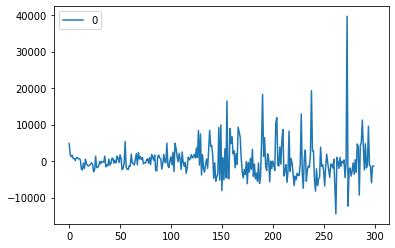

In [ ]:
#Plotagem dos resíduos
residuals = pd.DataFrame(model.resid())
residuals.plot()

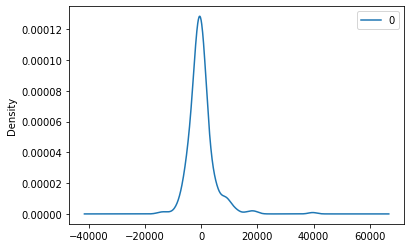

                  0
count    300.000000
mean      56.602514
std     4704.607373
min   -14453.444244
25%    -2198.874580
50%     -498.052384
75%     1283.457862
max    39674.756618


In [ ]:
#Plotagem da densidade dos resíduos
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [ ]:
test_data['ARIMA_Predictions'] = arima_pred

## Modelo Preditivo LSTM

First we'll scale our train and test data with MinMaxScaler

In [ ]:
# Definição do conjunto de treinamento e do conjunto de teste
dfarrec_train_lstm = dfarrec.iloc[:-14].copy()  
dfarrec_test_lstm =  dfarrec.iloc[-14:].copy()

In [ ]:
#Normalização dos dados
train_lstm = dfarrec_train_lstm.iloc[:,0:1].values
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_scaled_lstm = scaler.fit_transform(train_lstm) 
train_scaled_lstm

array([[3.25894392e-03],
       [0.00000000e+00],
       [4.95782543e-04],
       [5.57259579e-03],
       [2.57145879e-03],
       [3.88032470e-03],
       [1.36174939e-03],
       [6.82196779e-03],
       [8.78526666e-03],
       [8.08456067e-03],
       [9.41325789e-03],
       [1.91768688e-02],
       [2.01221608e-02],
       [1.31481530e-02],
       [2.18342632e-02],
       [1.46090589e-02],
       [2.71622729e-02],
       [2.03997990e-02],
       [1.49197493e-02],
       [1.54816362e-02],
       [1.60567440e-02],
       [1.64401491e-02],
       [1.80663159e-02],
       [2.17152754e-02],
       [1.80927576e-02],
       [1.37827547e-02],
       [3.89024036e-02],
       [1.91702583e-02],
       [2.08955816e-02],
       [1.94412861e-02],
       [2.27861657e-02],
       [2.04460721e-02],
       [2.44982681e-02],
       [2.35133134e-02],
       [2.34207673e-02],
       [3.94047965e-02],
       [2.68581930e-02],
       [2.41346942e-02],
       [3.33430286e-02],
       [3.52005606e-02],


In [ ]:
#Criação de uma estrutura de dados com 60 timesteps e 1 saída que neste caso será o preço de fechamento da ação
timesteps = 60
x_train_lstm = []
y_train_lstm = []
for i in range(timesteps, train_lstm.shape[0]):
    x_train_lstm.append(train_scaled_lstm[i-timesteps:i, 0]) #Utilização de 60 timesteps anteriores
    y_train_lstm.append(train_scaled_lstm[i, 0]) #O 120º preço de fechamento será o valor de y
x_train_lstm, y_train_lstm = np.array(x_train_lstm), np.array(y_train_lstm)

In [ ]:
x_train_lstm = np.reshape(x_train_lstm, (x_train_lstm.shape[0], x_train_lstm.shape[1], 1))

In [ ]:
#Criação da LSTM utilizando a biblioteca Keras

#seed=2016
#np.random.seed (seed)

# Inicialização da RNN
model_rnn = Sequential()

#O parâmetro return_sequences=True indica que a rede terá mais camadas a frente
#O parâmetro Dropout ajuda no ajuste do Overfitting

# Adiciona a primeira camada LSTM com o Dropout 
model_rnn.add(LSTM(units = 128, return_sequences = True, input_shape = (x_train_lstm.shape[1], 1)))
model_rnn.add(Dropout(0.3))

# Adiciona a segunda camada LSTM com o Dropout
model_rnn.add(LSTM(units = 64))
model_rnn.add(Dropout(0.3))

# Adiciona a camada de saída 
#model_rnn.add(Dense(16,init='uniform',activation='relu'))
model_rnn.add(Dense(1,activation='linear'))

# Compila a RNN, neste caso utilizando o otimizador 'Adam'
model_rnn.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mean_absolute_error'])

# Faz o treinamento da RNN utilizando o dataset de treinamento
model_rnn.fit(x_train_lstm, y_train_lstm, epochs = 100, batch_size = 32) 

#Mostra o resumo do modelo
model_rnn.summary()

Epoch 1/100
8/8 [==============================] - 4s 83ms/step - loss: 0.1093 - mean_absolute_error: 0.2504
Epoch 2/100
8/8 [==============================] - 1s 83ms/step - loss: 0.0145 - mean_absolute_error: 0.0867
Epoch 3/100
8/8 [==============================] - 1s 82ms/step - loss: 0.0089 - mean_absolute_error: 0.0735
Epoch 4/100
8/8 [==============================] - 1s 82ms/step - loss: 0.0095 - mean_absolute_error: 0.0723
Epoch 5/100
8/8 [==============================] - 1s 83ms/step - loss: 0.0071 - mean_absolute_error: 0.0575
Epoch 6/100
8/8 [==============================] - 1s 81ms/step - loss: 0.0050 - mean_absolute_error: 0.0490
Epoch 7/100
8/8 [==============================] - 1s 84ms/step - loss: 0.0072 - mean_absolute_error: 0.0574
Epoch 8/100
8/8 [==============================] - 1s 78ms/step - loss: 0.0048 - mean_absolute_error: 0.0486
Epoch 9/100
8/8 [==============================] - 1s 81ms/step - loss: 0.0064 - mean_absolute_error: 0.0545
Epoch 10/100
8/8 [=

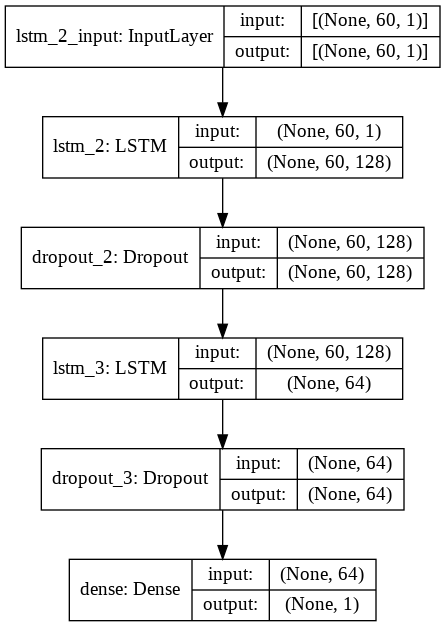

In [ ]:
#Visualização do modelo
plot_model(model_rnn, show_shapes=True) #Acrescente o parâmetro 'to_file='model_rnn.png' para exportar a figura

In [ ]:
#Carregamentos dos dados de teste para fazer as predições
test_lstm = dfarrec_test_lstm.iloc[:,0:1].values

In [ ]:
# Concatena os dados de treinamento e teste, pois os preços de fechamento anteriores não estão no conjunto de teste
combine = pd.concat((dfarrec_train_lstm['arrec'], dfarrec_test_lstm['arrec']), axis = 0)

# Tratamento do conjunto de teste considerando os timesteps anteriores
test_inputs = combine[len(combine) - len(dfarrec_test_lstm) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)

# Normalização dos dados
test_inputs = scaler.transform(test_inputs)

In [ ]:
# Predição utilizando os dados de teste
x_test_lstm = []
for i in range(timesteps, dfarrec_test_lstm.shape[0]+timesteps):
    x_test_lstm.append(test_inputs[i-timesteps:i, 0])
x_test_lstm = np.array(x_test_lstm)
x_test_lstm = np.reshape(x_test_lstm, (x_test_lstm.shape[0], x_test_lstm.shape[1], 1))
predictions_lstm = model_rnn.predict(x_test_lstm)

# Desnormaliza os dados
predictions_lstm = scaler.inverse_transform(predictions_lstm)

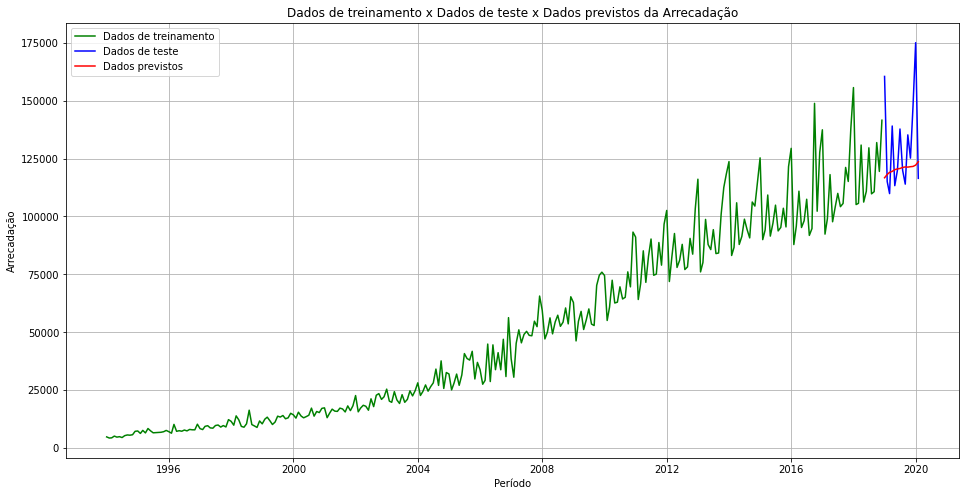

In [ ]:
#Plotagem dos dados de treinamento, teste e previsão
plt.figure(figsize=(16,8))
plt.plot(dfarrec_train_lstm.index, dfarrec_train_lstm, color='green', label = 'Dados de treinamento')
plt.plot(dfarrec_test_lstm.index, dfarrec_test_lstm, color = 'blue', label = 'Dados de teste')
plt.plot(dfarrec_test_lstm.index, predictions_lstm, color = 'red', label = 'Dados previstos')
plt.title('Dados de treinamento x Dados de teste x Dados previstos da Arrecadação')
plt.xlabel('Período')
plt.ylabel('Arrecadação')
plt.legend()
plt.grid(True)
#plt.savefig('lstm1.pdf')
plt.show()

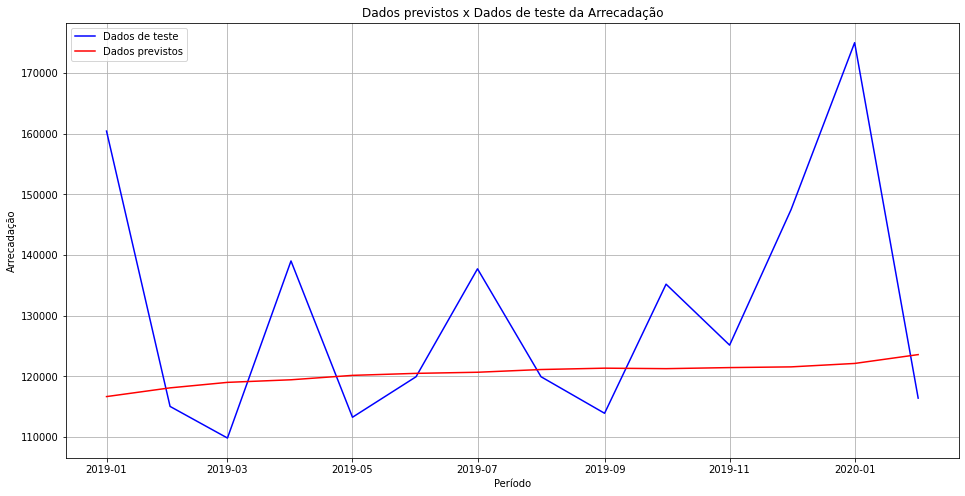

In [ ]:
#Plotagem dos dados de teste e dados previstos
plt.figure(figsize=(16,8))
plt.plot(dfarrec_test_lstm.index, test_lstm, color = 'blue', label = 'Dados de teste')
plt.plot(dfarrec_test_lstm.index, predictions_lstm, color = 'red', label = 'Dados previstos')
plt.title('Dados previstos x Dados de teste da Arrecadação')
plt.xlabel('Período')
plt.ylabel('Arrecadação')
plt.legend()
plt.grid(True)
#plt.savefig('lstm2.pdf')
plt.show()

In [ ]:
#Cálculo do erro
print('MAE: ', mean_absolute_error(dfarrec_test_lstm,predictions_lstm))
print('MSE: ', mean_squared_error(dfarrec_test_lstm,predictions_lstm))
print('RMSE: ', np.sqrt(mean_squared_error(dfarrec_test_lstm,predictions_lstm)))

MAE:  15159.853794642857
MSE:  464928611.8123169
RMSE:  21562.203315345974


In [ ]:
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

Before creating LSTM model we should create a Time Series Generator object.

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               161600    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm_model.fit_generator(generator,epochs=20)

Epoch 1/20
290/290 [==============================] - 4s 10ms/step - loss: 0.0269
Epoch 2/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0047
Epoch 3/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0073
Epoch 4/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0043
Epoch 5/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0052
Epoch 6/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0043
Epoch 7/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0039
Epoch 8/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0046
Epoch 9/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0050
Epoch 10/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0029
Epoch 11/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0020
Epoch 12/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0029
Epoch 13/20
2

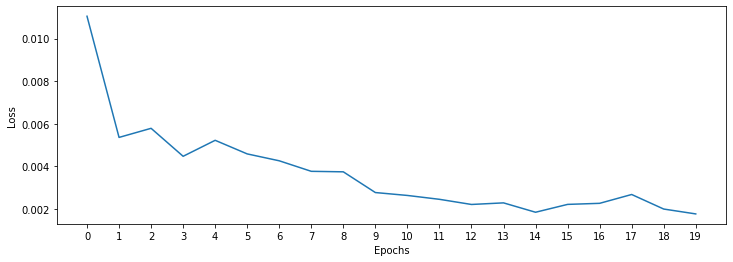

In [ ]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [ ]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

As you know we scaled our data that's why we have to inverse it to see true predictions.

In [ ]:
lstm_predictions_scaled

[array([0.7392362], dtype=float32),
 array([0.85764617], dtype=float32),
 array([0.74661165], dtype=float32),
 array([0.7634965], dtype=float32),
 array([0.8542656], dtype=float32),
 array([0.7650373], dtype=float32),
 array([0.7677406], dtype=float32),
 array([0.87268454], dtype=float32),
 array([0.8191243], dtype=float32),
 array([0.93390137], dtype=float32),
 array([1.0454565], dtype=float32),
 array([0.8151505], dtype=float32)]

In [ ]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [ ]:
lstm_predictions

array([[119725.20006078],
       [138206.9867273 ],
       [120876.38690966],
       [123511.82704008],
       [137679.33306229],
       [123752.31661534],
       [124174.25720322],
       [140554.22080153],
       [132194.37521476],
       [150109.12746686],
       [167520.99136341],
       [131574.13538909]])

In [ ]:
test_data['LSTM_Predictions'] = lstm_predictions

In [ ]:
test_data

y  ARIMA_Predictions  LSTM_Predictions
ds                                                     
2019-03-01  109854      114538.221536     119725.200061
2019-04-01  139030      136135.889426     138206.986727
2019-05-01  113278      114385.365859     120876.386910
2019-06-01  119946      119389.395546     123511.827040
2019-07-01  137735      131883.349396     137679.333062
2019-08-01  119951      117439.879777     123752.316615
2019-09-01  113933      118629.422669     124174.257203
2019-10-01  135202      143127.237904     140554.220802
2019-11-01  125161      128216.866629     132194.375215
2019-12-01  147501      151476.405793     150109.127467
2020-01-01  174991      167102.885630     167520.991363
2020-02-01  116430      118813.306616     131574.135389

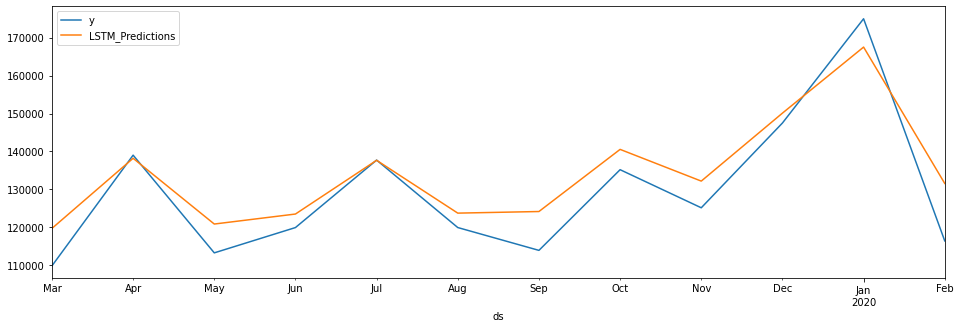

In [ ]:
test_data['y'].plot(figsize = (16,5), legend=True)
test_data['LSTM_Predictions'].plot(legend = True);

In [ ]:
lstm_rmse_error = rmse(test_data['y'], test_data["LSTM_Predictions"])
lstm_mse_error = lstm_rmse_error**2
mean_value = df['y'].mean()

print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMean: {mean_value}')

MSE Error: 54830652.711122535
RMSE Error: 7404.772292996087
Mean: 54008.87898089172


## Modelo Preditivo PROPHET

In [ ]:
# Definição do conjunto de treinamento e do conjunto de teste
dfarrec_train_prophet = dfarrec.iloc[:-14].copy()  
dfarrec_test_prophet =  dfarrec.iloc[-14:].copy()

In [ ]:
#Renomeia as colunas 'arrec' para 'y' e 'Data' para 'ds' do conjunto de treinamento e teste
dfarrec_train_prophet = pd.DataFrame({"ds": dfarrec_train_prophet.index, "y": dfarrec_train_prophet.arrec})
dfarrec_train_prophet.reset_index(drop = True, inplace = True)
dfarrec_test_prophet = pd.DataFrame({"ds_test": dfarrec_test_prophet.index, "y_test": dfarrec_test_prophet.arrec})
dfarrec_test_prophet.reset_index(drop = True, inplace = True)

In [ ]:
dfarrec_train_prophet.head()

ds     y
0 1994-01-01  4836
1 1994-02-01  4343
2 1994-03-01  4418
3 1994-04-01  5186
4 1994-05-01  4732

In [ ]:
dfarrec_test_prophet.head(30)

ds_test  y_test
0  2019-01-01  160426
1  2019-02-01  115062
2  2019-03-01  109854
3  2019-04-01  139030
4  2019-05-01  113278
5  2019-06-01  119946
6  2019-07-01  137735
7  2019-08-01  119951
8  2019-09-01  113933
9  2019-10-01  135202
10 2019-11-01  125161
11 2019-12-01  147501
12 2020-01-01  174991
13 2020-02-01  116430

In [ ]:
#Utiliza a biblioteca Prophet para fazer a previsão
prophet_model = Prophet(changepoint_prior_scale=0.05, interval_width=0.95, daily_seasonality=False)
prophet_model.fit(dfarrec_train_prophet)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Text(39.125, 0.5, 'Arrecadação')

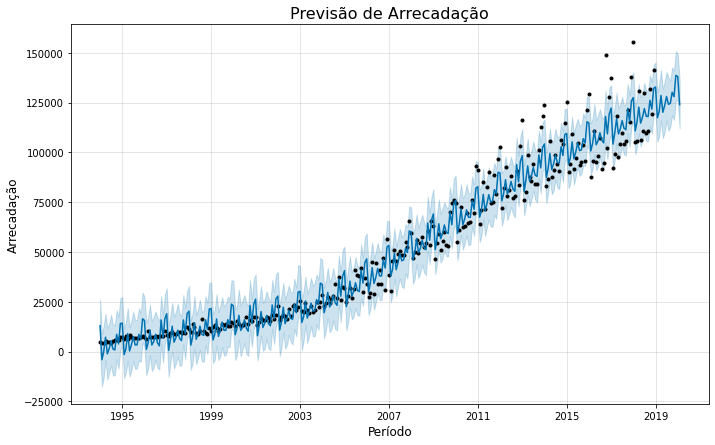

In [ ]:
#Cria datas futuras e faz a predição
prophet_forecast = prophet_model.make_future_dataframe(periods=14, freq='MS')
prophet_forecast = prophet_model.predict(prophet_forecast)

#Plotagem do gráfico de previsão
fig = prophet_model.plot(prophet_forecast)
ax1 = fig.gca()
ax1.set_title("Previsão de Arrecadação", fontsize=16)
ax1.set_xlabel("Período", fontsize=12)
ax1.set_ylabel("Arrecadação", fontsize=12)

In [ ]:
#Seleciona os dados previstos apenas para o período de teste
prophet_forecast = prophet_forecast[prophet_forecast['ds'] > '2018-12-01']
prophet_forecast.head()

ds          trend  ...  multiplicative_terms_upper           yhat
300 2019-01-01  124356.240643  ...                         0.0  132835.088516
301 2019-02-01  124850.303486  ...                         0.0  117395.338242
302 2019-03-01  125296.553796  ...                         0.0  120361.823119
303 2019-04-01  125790.616638  ...                         0.0  128578.085779
304 2019-05-01  126268.741970  ...                         0.0  120152.928112
305 2019-06-01  126762.804813  ...                         0.0  123669.021680
306 2019-07-01  127240.930144  ...                         0.0  128052.490465
307 2019-08-01  127734.992987  ...                         0.0  124190.784839
308 2019-09-01  128229.055830  ...                         0.0  124583.851815
309 2019-10-01  128707.181161  ...                         0.0  130186.307804
310 2019-11-01  129201.244004  ...                         0.0  127972.033460
311 2019-12-01  129679.369336  ...                         0.0  138680.233078
312 2020-01-01  130173.432178  ...                         0.0  138119.883251
313 2020-02-01  130667.495021  ...                         0.0  124004.528851

[14 rows x 16 columns]

In [ ]:
#Escolhe as datas ('ds' e 'ds_test') como índices
prophet_forecast.set_index(prophet_forecast['ds'], inplace=True) 
dfarrec_test_prophet.set_index(dfarrec_test_prophet['ds_test'], inplace=True) 
dfarrec_train_prophet.set_index(dfarrec_train_prophet['ds'], inplace=True) 

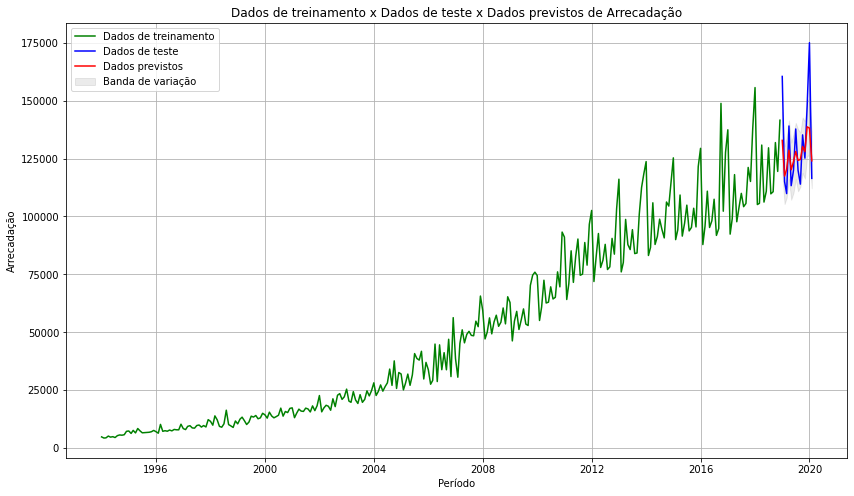

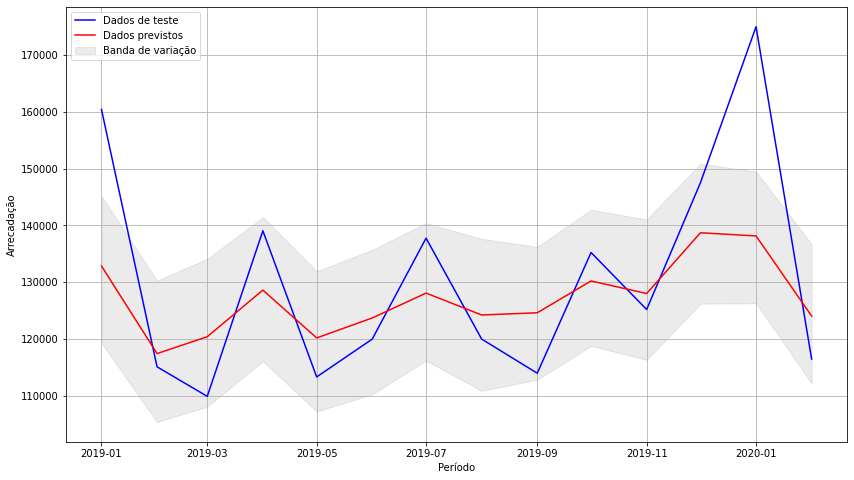

In [ ]:
#Plotagem do comparativo entre o preço previsto e o dataset
n = dfarrec_train_prophet.shape[0]
plt.figure(figsize=(14,8))
plt.title('Dados de treinamento x Dados de teste x Dados previstos de Arrecadação')
plt.plot(dfarrec_train_prophet['y'], 'green', label='Dados de treinamento')
plt.plot(dfarrec_test_prophet['y_test'], color = 'blue', label='Dados de teste')
plt.plot(prophet_forecast['yhat'][-n:], color = 'red', label = 'Dados previstos')
plt.fill_between(prophet_forecast.index[-n:], prophet_forecast['yhat_lower'][-n:], prophet_forecast['yhat_upper'][-n:], color='k', alpha=.08, label="Banda de variação")
plt.xlabel("Período")
plt.ylabel("Arrecadação")
plt.legend()
#plt.savefig('prophet1.pdf')
plt.grid(True)

#Plotagem do comparativo entre o preço previsto e o preço de validação
plt.figure(figsize=(14,8))
plt.plot(dfarrec_test_prophet['y_test'], color = 'blue', label='Dados de teste')
plt.plot(prophet_forecast['yhat'], color = 'red', label = 'Dados previstos')
plt.fill_between(prophet_forecast.index[-n:], prophet_forecast['yhat_lower'][-n:], prophet_forecast['yhat_upper'][-n:], color='k', alpha=.08, label="Banda de variação")
plt.xlabel("Período")
plt.ylabel("Arrecadação")
plt.legend()
plt.grid(True)
#plt.savefig('prophet2.pdf')
plt.show()

In [ ]:
#Cálculo do erro
print('MAE: ', mean_absolute_error(dfarrec_test_prophet['y_test'],prophet_forecast['yhat']))
print('MSE: ', mean_squared_error(dfarrec_test_prophet['y_test'],prophet_forecast['yhat']))
print('RMSE: ', np.sqrt(mean_squared_error(dfarrec_test_prophet['y_test'],prophet_forecast['yhat'])))

MAE:  10510.587230358593
MSE:  200026457.37499568
RMSE:  14143.07100226099


## Comparativo entre os modelos

In [ ]:
rmse_errors = [arima_rmse_error, lstm_rmse_error, prophet_rmse_error]
mse_errors = [arima_mse_error, lstm_mse_error, prophet_mse_error]
errors = pd.DataFrame({"Models" : ["ARIMA", "LSTM", "Prophet"],"RMSE Errors" : rmse_errors, "MSE Errors" : mse_errors})

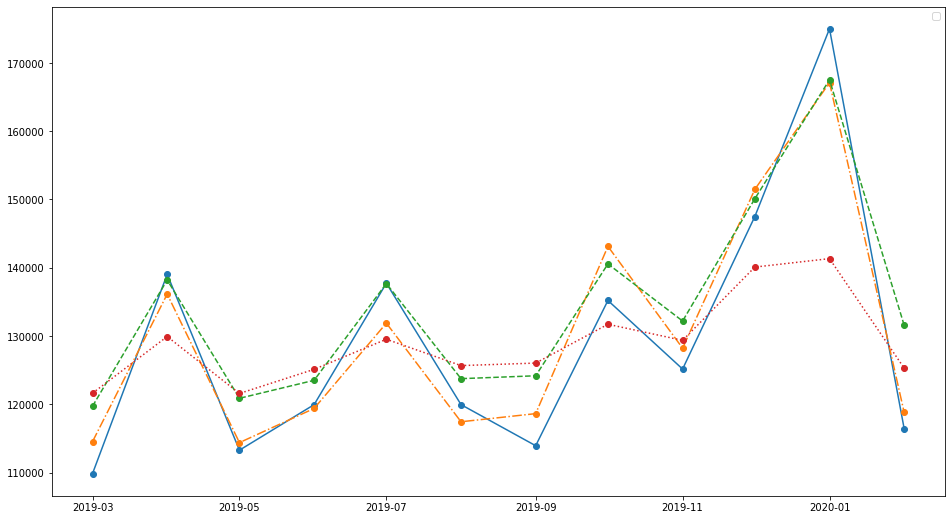

In [ ]:
plt.figure(figsize=(16,9))
plt.plot_date(test_data.index, test_data["y"], linestyle="-")
plt.plot_date(test_data.index, test_data["ARIMA_Predictions"], linestyle="-.")
plt.plot_date(test_data.index, test_data["LSTM_Predictions"], linestyle="--")
plt.plot_date(test_data.index, test_data["Prophet_Predictions"], linestyle=":")
plt.legend()
plt.show()

In [ ]:
print(f"Mean: {test_data['y'].mean()}")
errors

Mean: 129417.66666666667


Models   RMSE Errors    MSE Errors
0    ARIMA   4567.200703  2.085932e+07
1     LSTM   7404.772293  5.483065e+07
2  Prophet  12449.931929  1.550008e+08

In [ ]:
test_data

y  ARIMA_Predictions  LSTM_Predictions  Prophet_Predictions
ds                                                                          
2019-03-01  109854      114538.221536     119725.200061        121630.326801
2019-04-01  139030      136135.889426     138206.986727        129922.933794
2019-05-01  113278      114385.365859     120876.386910        121583.844712
2019-06-01  119946      119389.395546     123511.827040        125117.610239
2019-07-01  137735      131883.349396     137679.333062        129526.413885
2019-08-01  119951      117439.879777     123752.316615        125666.318949
2019-09-01  113933      118629.422669     124174.257203        126033.950733
2019-10-01  135202      143127.237904     140554.220802        131719.143913
2019-11-01  125161      128216.866629     132194.375215        129363.723922
2019-12-01  147501      151476.405793     150109.127467        140094.810948
2020-01-01  174991      167102.885630     167520.991363        141330.877965
2020-02-01  116430      118813.306616     131574.135389        125291.666429

## **MODELOS PREDITIVOS DA ARRECADAÇÃO FEDERAL**

## Modelo preditivo ARIMA

In [ ]:
# Definição do conjunto de treinamento e do conjunto de teste
dfarrec_train_arima = dfarrec.iloc[:-14].copy()  
dfarrec_test_arima =  dfarrec.iloc[-14:].copy()

In [ ]:
# Utilização do auto-arima para identificar o melhor modelo de forma automática
model = auto_arima(dfarrec_train_arima['arrec'], start_p=1, start_q=1, max_p=3, max_q=3, d=1, stationary = False, start_P=0, D=1, trace=True,
                   error_action='ignore', suppress_warnings=True, stepwise=True, seasonal= True, m=12)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=5700.993, Time=1.27 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5922.820, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5785.124, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5699.424, Time=0.98 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=5781.815, Time=0.12 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=5699.614, Time=1.34 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=5718.844, Time=0.91 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=5720.122, Time=0.81 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=5692.038, Time=5.42 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=inf, Time=7.10 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=5719.306, Time=1.11 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=5852.188, Time=1.73 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=5694.244, Time=7.47 sec
 ARIMA(0,1,2)(1,1,2)[12]             : AIC=inf, Time=6.06 sec
 ARIMA(1,1,0)(1,1,2)[12]     

In [ ]:
print(model.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  300
Model:             SARIMAX(0, 1, 1)x(1, 1, [1, 2], 12)   Log Likelihood               -2841.019
Date:                                 Wed, 10 Feb 2021   AIC                           5692.038
Time:                                         18:51:06   BIC                           5710.336
Sample:                                              0   HQIC                          5699.372
                                                 - 300                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8176      0.030    -27.451      0.000      -0.876      -0

As we can see best arima model chosen by auto_arima() is SARIMAX(2, 1, 1)x(4, 0, 3, 12)

Let's split the data into train and test set

In [ ]:
# Treinamento do modelo
model.fit(dfarrec_train_arima['arrec'])

ARIMA(maxiter=50, method='lbfgs', order=(0, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(1, 1, 2, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [ ]:
#Faz a predição 
forecast_arima = model.predict(n_periods=len(dfarrec_test_arima['arrec']))
forecast_arima = pd.DataFrame(forecast_arima, index = dfarrec_test_arima.index,columns=['Prediction'])
conf_int = model.predict(len(dfarrec_test_arima['arrec']), return_conf_int=True, alpha = 0.05) #Pega o intervalo de confiança

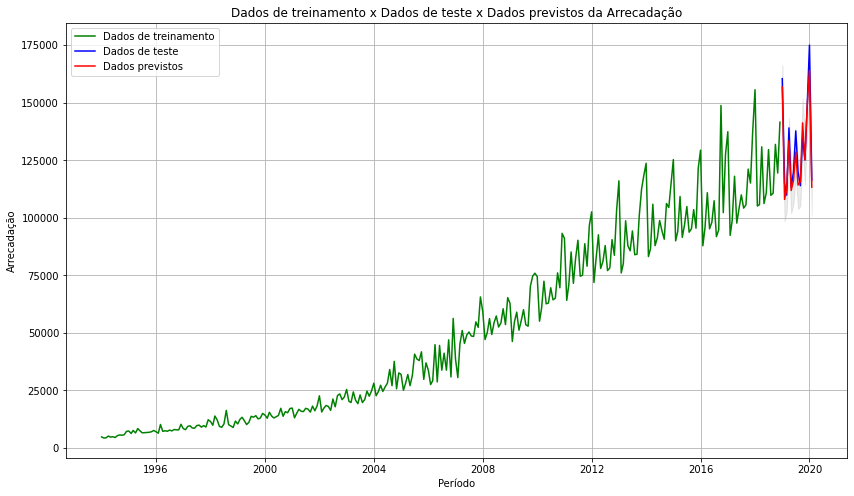

In [ ]:
#Plotagem dos dados de treinamento, teste e previsão
plt.figure(figsize=(14,8))
plt.title('Dados de treinamento x Dados de teste x Dados previstos da Arrecadação')
plt.plot(dfarrec_train_arima['arrec'], color='green', label = 'Dados de treinamento')
plt.plot(dfarrec_test_arima['arrec'], color = 'blue', label = 'Dados de teste')
plt.fill_between(dfarrec_test_arima.index, conf_int[1][:,0], conf_int[1][:,1], 
                 color='k', alpha=.08)
plt.plot(forecast_arima['Prediction'], color = 'red', label = 'Dados previstos')
plt.xlabel('Período')
plt.ylabel('Arrecadação')
plt.legend()
plt.grid(True)
#plt.savefig('arima1.pdf')
plt.show()

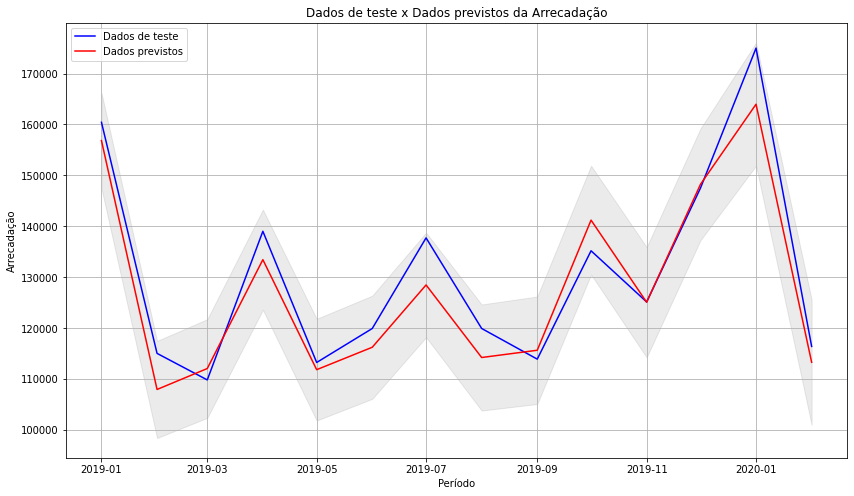

In [ ]:
#Plotagem dos dados de teste e previsão
plt.figure(figsize=(14,8))
plt.title('Dados de teste x Dados previstos da Arrecadação')
plt.plot(dfarrec_test_arima['arrec'], color = 'blue', label = 'Dados de teste')
plt.fill_between(dfarrec_test_arima.index, conf_int[1][:,0], conf_int[1][:,1], 
                 color='k', alpha=.08)
plt.plot(forecast_arima['Prediction'], color = 'red', label = 'Dados previstos')
plt.xlabel('Período')
plt.ylabel('Arrecadação')
plt.legend()
plt.grid(True)
#plt.savefig('arima2.pdf')
plt.show()

In [ ]:
#Cálculo do erro
mse = mean_squared_error(dfarrec_test_arima['arrec'], forecast_arima['Prediction'])
print('MSE: '+str(mse))
mae = mean_absolute_error(dfarrec_test_arima['arrec'], forecast_arima['Prediction'])
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(dfarrec_test_arima['arrec'], forecast_arima['Prediction']))
print('RMSE: '+str(rmse))

MSE: 28819248.34610119
MAE: 4372.347419805619
RMSE: 5368.356205217869


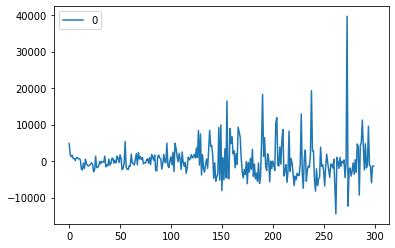

In [ ]:
#Plotagem dos resíduos
residuals = pd.DataFrame(model.resid())
residuals.plot()

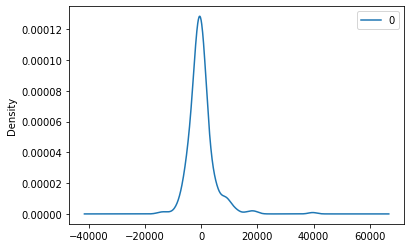

                  0
count    300.000000
mean      56.602514
std     4704.607373
min   -14453.444244
25%    -2198.874580
50%     -498.052384
75%     1283.457862
max    39674.756618


In [ ]:
#Plotagem da densidade dos resíduos
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [ ]:
test_data['ARIMA_Predictions'] = arima_pred

## Modelo Preditivo LSTM

First we'll scale our train and test data with MinMaxScaler

In [ ]:
# Definição do conjunto de treinamento e do conjunto de teste
dfarrec_train_lstm = dfarrec.iloc[:-14].copy()  
dfarrec_test_lstm =  dfarrec.iloc[-14:].copy()

In [ ]:
#Normalização dos dados
train_lstm = dfarrec_train_lstm.iloc[:,0:1].values
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_scaled_lstm = scaler.fit_transform(train_lstm) 
train_scaled_lstm

array([[3.25894392e-03],
       [0.00000000e+00],
       [4.95782543e-04],
       [5.57259579e-03],
       [2.57145879e-03],
       [3.88032470e-03],
       [1.36174939e-03],
       [6.82196779e-03],
       [8.78526666e-03],
       [8.08456067e-03],
       [9.41325789e-03],
       [1.91768688e-02],
       [2.01221608e-02],
       [1.31481530e-02],
       [2.18342632e-02],
       [1.46090589e-02],
       [2.71622729e-02],
       [2.03997990e-02],
       [1.49197493e-02],
       [1.54816362e-02],
       [1.60567440e-02],
       [1.64401491e-02],
       [1.80663159e-02],
       [2.17152754e-02],
       [1.80927576e-02],
       [1.37827547e-02],
       [3.89024036e-02],
       [1.91702583e-02],
       [2.08955816e-02],
       [1.94412861e-02],
       [2.27861657e-02],
       [2.04460721e-02],
       [2.44982681e-02],
       [2.35133134e-02],
       [2.34207673e-02],
       [3.94047965e-02],
       [2.68581930e-02],
       [2.41346942e-02],
       [3.33430286e-02],
       [3.52005606e-02],


In [ ]:
#Criação de uma estrutura de dados com 60 timesteps e 1 saída que neste caso será o preço de fechamento da ação
timesteps = 60
x_train_lstm = []
y_train_lstm = []
for i in range(timesteps, train_lstm.shape[0]):
    x_train_lstm.append(train_scaled_lstm[i-timesteps:i, 0]) #Utilização de 60 timesteps anteriores
    y_train_lstm.append(train_scaled_lstm[i, 0]) #O 120º preço de fechamento será o valor de y
x_train_lstm, y_train_lstm = np.array(x_train_lstm), np.array(y_train_lstm)

In [ ]:
x_train_lstm = np.reshape(x_train_lstm, (x_train_lstm.shape[0], x_train_lstm.shape[1], 1))

In [ ]:
#Criação da LSTM utilizando a biblioteca Keras

#seed=2016
#np.random.seed (seed)

# Inicialização da RNN
model_rnn = Sequential()

#O parâmetro return_sequences=True indica que a rede terá mais camadas a frente
#O parâmetro Dropout ajuda no ajuste do Overfitting

# Adiciona a primeira camada LSTM com o Dropout 
model_rnn.add(LSTM(units = 128, return_sequences = True, input_shape = (x_train_lstm.shape[1], 1)))
model_rnn.add(Dropout(0.3))

# Adiciona a segunda camada LSTM com o Dropout
model_rnn.add(LSTM(units = 64))
model_rnn.add(Dropout(0.3))

# Adiciona a camada de saída 
#model_rnn.add(Dense(16,init='uniform',activation='relu'))
model_rnn.add(Dense(1,activation='linear'))

# Compila a RNN, neste caso utilizando o otimizador 'Adam'
model_rnn.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mean_absolute_error'])

# Faz o treinamento da RNN utilizando o dataset de treinamento
model_rnn.fit(x_train_lstm, y_train_lstm, epochs = 100, batch_size = 32) 

#Mostra o resumo do modelo
model_rnn.summary()

Epoch 1/100
8/8 [==============================] - 4s 83ms/step - loss: 0.1093 - mean_absolute_error: 0.2504
Epoch 2/100
8/8 [==============================] - 1s 83ms/step - loss: 0.0145 - mean_absolute_error: 0.0867
Epoch 3/100
8/8 [==============================] - 1s 82ms/step - loss: 0.0089 - mean_absolute_error: 0.0735
Epoch 4/100
8/8 [==============================] - 1s 82ms/step - loss: 0.0095 - mean_absolute_error: 0.0723
Epoch 5/100
8/8 [==============================] - 1s 83ms/step - loss: 0.0071 - mean_absolute_error: 0.0575
Epoch 6/100
8/8 [==============================] - 1s 81ms/step - loss: 0.0050 - mean_absolute_error: 0.0490
Epoch 7/100
8/8 [==============================] - 1s 84ms/step - loss: 0.0072 - mean_absolute_error: 0.0574
Epoch 8/100
8/8 [==============================] - 1s 78ms/step - loss: 0.0048 - mean_absolute_error: 0.0486
Epoch 9/100
8/8 [==============================] - 1s 81ms/step - loss: 0.0064 - mean_absolute_error: 0.0545
Epoch 10/100
8/8 [=

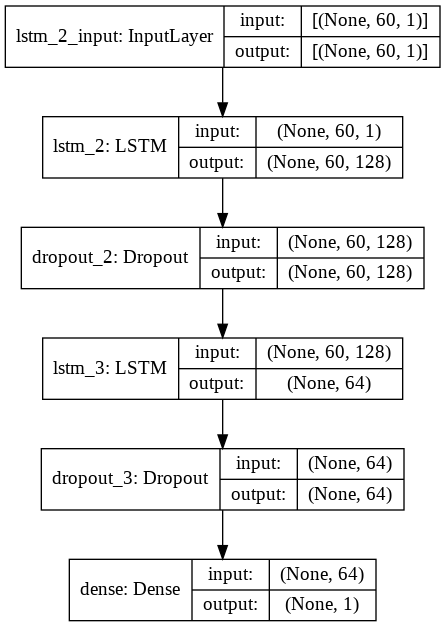

In [ ]:
#Visualização do modelo
plot_model(model_rnn, show_shapes=True) #Acrescente o parâmetro 'to_file='model_rnn.png' para exportar a figura

In [ ]:
#Carregamentos dos dados de teste para fazer as predições
test_lstm = dfarrec_test_lstm.iloc[:,0:1].values

In [ ]:
# Concatena os dados de treinamento e teste, pois os preços de fechamento anteriores não estão no conjunto de teste
combine = pd.concat((dfarrec_train_lstm['arrec'], dfarrec_test_lstm['arrec']), axis = 0)

# Tratamento do conjunto de teste considerando os timesteps anteriores
test_inputs = combine[len(combine) - len(dfarrec_test_lstm) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)

# Normalização dos dados
test_inputs = scaler.transform(test_inputs)

In [ ]:
# Predição utilizando os dados de teste
x_test_lstm = []
for i in range(timesteps, dfarrec_test_lstm.shape[0]+timesteps):
    x_test_lstm.append(test_inputs[i-timesteps:i, 0])
x_test_lstm = np.array(x_test_lstm)
x_test_lstm = np.reshape(x_test_lstm, (x_test_lstm.shape[0], x_test_lstm.shape[1], 1))
predictions_lstm = model_rnn.predict(x_test_lstm)

# Desnormaliza os dados
predictions_lstm = scaler.inverse_transform(predictions_lstm)

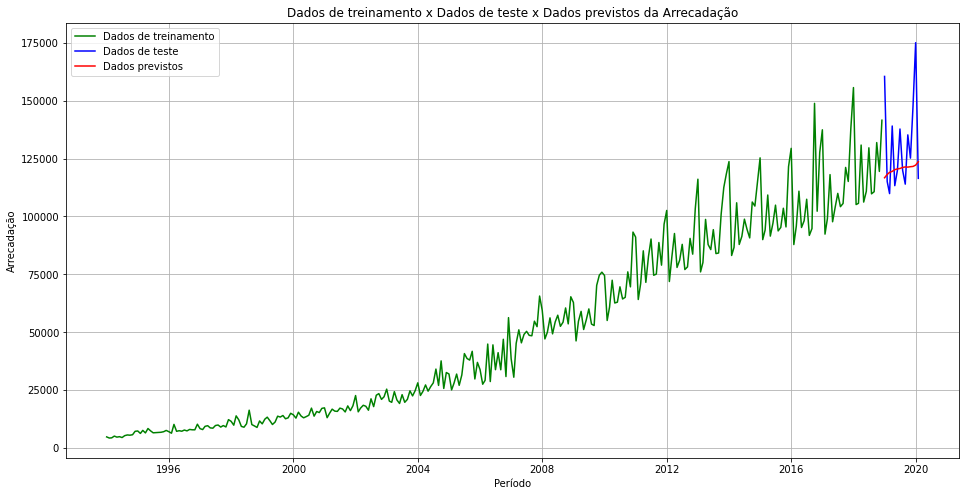

In [ ]:
#Plotagem dos dados de treinamento, teste e previsão
plt.figure(figsize=(16,8))
plt.plot(dfarrec_train_lstm.index, dfarrec_train_lstm, color='green', label = 'Dados de treinamento')
plt.plot(dfarrec_test_lstm.index, dfarrec_test_lstm, color = 'blue', label = 'Dados de teste')
plt.plot(dfarrec_test_lstm.index, predictions_lstm, color = 'red', label = 'Dados previstos')
plt.title('Dados de treinamento x Dados de teste x Dados previstos da Arrecadação')
plt.xlabel('Período')
plt.ylabel('Arrecadação')
plt.legend()
plt.grid(True)
#plt.savefig('lstm1.pdf')
plt.show()

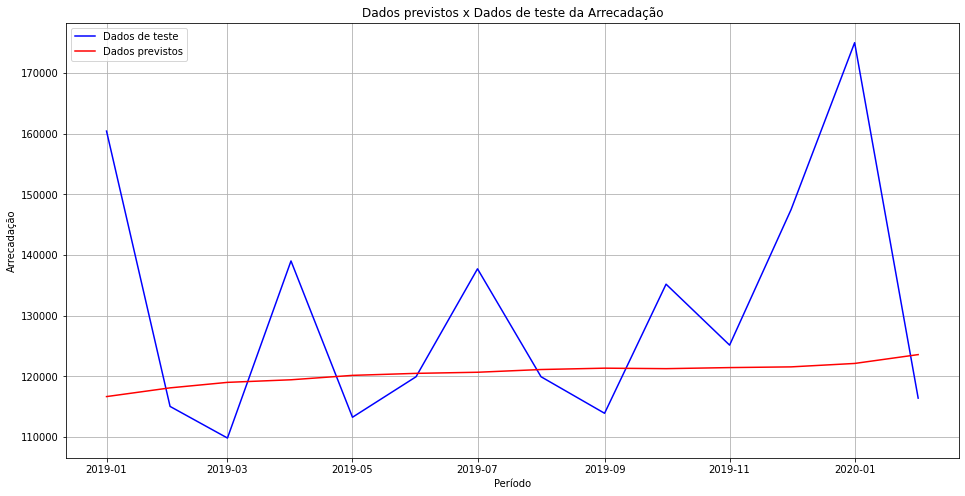

In [ ]:
#Plotagem dos dados de teste e dados previstos
plt.figure(figsize=(16,8))
plt.plot(dfarrec_test_lstm.index, test_lstm, color = 'blue', label = 'Dados de teste')
plt.plot(dfarrec_test_lstm.index, predictions_lstm, color = 'red', label = 'Dados previstos')
plt.title('Dados previstos x Dados de teste da Arrecadação')
plt.xlabel('Período')
plt.ylabel('Arrecadação')
plt.legend()
plt.grid(True)
#plt.savefig('lstm2.pdf')
plt.show()

In [ ]:
#Cálculo do erro
print('MAE: ', mean_absolute_error(dfarrec_test_lstm,predictions_lstm))
print('MSE: ', mean_squared_error(dfarrec_test_lstm,predictions_lstm))
print('RMSE: ', np.sqrt(mean_squared_error(dfarrec_test_lstm,predictions_lstm)))

MAE:  15159.853794642857
MSE:  464928611.8123169
RMSE:  21562.203315345974


In [ ]:
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

Before creating LSTM model we should create a Time Series Generator object.

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               161600    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm_model.fit_generator(generator,epochs=20)

Epoch 1/20
290/290 [==============================] - 4s 10ms/step - loss: 0.0269
Epoch 2/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0047
Epoch 3/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0073
Epoch 4/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0043
Epoch 5/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0052
Epoch 6/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0043
Epoch 7/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0039
Epoch 8/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0046
Epoch 9/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0050
Epoch 10/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0029
Epoch 11/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0020
Epoch 12/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0029
Epoch 13/20
2

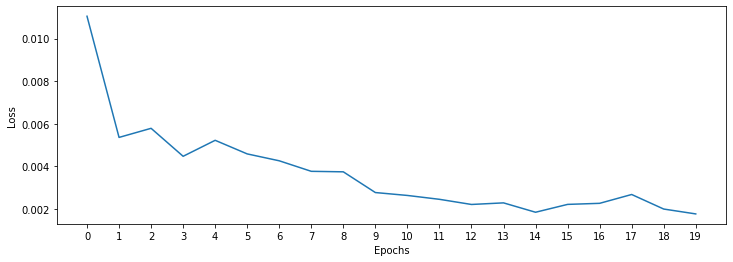

In [ ]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [ ]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

As you know we scaled our data that's why we have to inverse it to see true predictions.

In [ ]:
lstm_predictions_scaled

[array([0.7392362], dtype=float32),
 array([0.85764617], dtype=float32),
 array([0.74661165], dtype=float32),
 array([0.7634965], dtype=float32),
 array([0.8542656], dtype=float32),
 array([0.7650373], dtype=float32),
 array([0.7677406], dtype=float32),
 array([0.87268454], dtype=float32),
 array([0.8191243], dtype=float32),
 array([0.93390137], dtype=float32),
 array([1.0454565], dtype=float32),
 array([0.8151505], dtype=float32)]

In [ ]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [ ]:
lstm_predictions

array([[119725.20006078],
       [138206.9867273 ],
       [120876.38690966],
       [123511.82704008],
       [137679.33306229],
       [123752.31661534],
       [124174.25720322],
       [140554.22080153],
       [132194.37521476],
       [150109.12746686],
       [167520.99136341],
       [131574.13538909]])

In [ ]:
test_data['LSTM_Predictions'] = lstm_predictions

In [ ]:
test_data

y  ARIMA_Predictions  LSTM_Predictions
ds                                                     
2019-03-01  109854      114538.221536     119725.200061
2019-04-01  139030      136135.889426     138206.986727
2019-05-01  113278      114385.365859     120876.386910
2019-06-01  119946      119389.395546     123511.827040
2019-07-01  137735      131883.349396     137679.333062
2019-08-01  119951      117439.879777     123752.316615
2019-09-01  113933      118629.422669     124174.257203
2019-10-01  135202      143127.237904     140554.220802
2019-11-01  125161      128216.866629     132194.375215
2019-12-01  147501      151476.405793     150109.127467
2020-01-01  174991      167102.885630     167520.991363
2020-02-01  116430      118813.306616     131574.135389

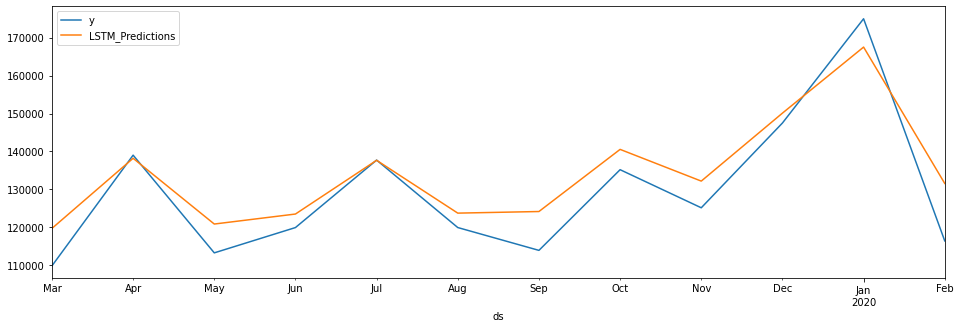

In [ ]:
test_data['y'].plot(figsize = (16,5), legend=True)
test_data['LSTM_Predictions'].plot(legend = True);

In [ ]:
lstm_rmse_error = rmse(test_data['y'], test_data["LSTM_Predictions"])
lstm_mse_error = lstm_rmse_error**2
mean_value = df['y'].mean()

print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMean: {mean_value}')

MSE Error: 54830652.711122535
RMSE Error: 7404.772292996087
Mean: 54008.87898089172


## Modelo Preditivo PROPHET

In [ ]:
# Definição do conjunto de treinamento e do conjunto de teste
dfarrec_train_prophet = dfarrec.iloc[:-14].copy()  
dfarrec_test_prophet =  dfarrec.iloc[-14:].copy()

In [ ]:
#Renomeia as colunas 'arrec' para 'y' e 'Data' para 'ds' do conjunto de treinamento e teste
dfarrec_train_prophet = pd.DataFrame({"ds": dfarrec_train_prophet.index, "y": dfarrec_train_prophet.arrec})
dfarrec_train_prophet.reset_index(drop = True, inplace = True)
dfarrec_test_prophet = pd.DataFrame({"ds_test": dfarrec_test_prophet.index, "y_test": dfarrec_test_prophet.arrec})
dfarrec_test_prophet.reset_index(drop = True, inplace = True)

In [ ]:
dfarrec_train_prophet.head()

ds     y
0 1994-01-01  4836
1 1994-02-01  4343
2 1994-03-01  4418
3 1994-04-01  5186
4 1994-05-01  4732

In [ ]:
dfarrec_test_prophet.head(30)

ds_test  y_test
0  2019-01-01  160426
1  2019-02-01  115062
2  2019-03-01  109854
3  2019-04-01  139030
4  2019-05-01  113278
5  2019-06-01  119946
6  2019-07-01  137735
7  2019-08-01  119951
8  2019-09-01  113933
9  2019-10-01  135202
10 2019-11-01  125161
11 2019-12-01  147501
12 2020-01-01  174991
13 2020-02-01  116430

In [ ]:
#Utiliza a biblioteca Prophet para fazer a previsão
prophet_model = Prophet(changepoint_prior_scale=0.05, interval_width=0.95, daily_seasonality=False)
prophet_model.fit(dfarrec_train_prophet)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Text(39.125, 0.5, 'Arrecadação')

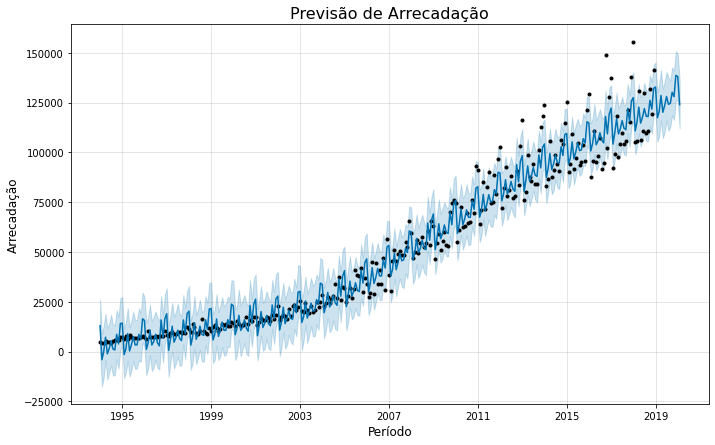

In [ ]:
#Cria datas futuras e faz a predição
prophet_forecast = prophet_model.make_future_dataframe(periods=14, freq='MS')
prophet_forecast = prophet_model.predict(prophet_forecast)

#Plotagem do gráfico de previsão
fig = prophet_model.plot(prophet_forecast)
ax1 = fig.gca()
ax1.set_title("Previsão de Arrecadação", fontsize=16)
ax1.set_xlabel("Período", fontsize=12)
ax1.set_ylabel("Arrecadação", fontsize=12)

In [ ]:
#Seleciona os dados previstos apenas para o período de teste
prophet_forecast = prophet_forecast[prophet_forecast['ds'] > '2018-12-01']
prophet_forecast.head()

ds          trend  ...  multiplicative_terms_upper           yhat
300 2019-01-01  124356.240643  ...                         0.0  132835.088516
301 2019-02-01  124850.303486  ...                         0.0  117395.338242
302 2019-03-01  125296.553796  ...                         0.0  120361.823119
303 2019-04-01  125790.616638  ...                         0.0  128578.085779
304 2019-05-01  126268.741970  ...                         0.0  120152.928112
305 2019-06-01  126762.804813  ...                         0.0  123669.021680
306 2019-07-01  127240.930144  ...                         0.0  128052.490465
307 2019-08-01  127734.992987  ...                         0.0  124190.784839
308 2019-09-01  128229.055830  ...                         0.0  124583.851815
309 2019-10-01  128707.181161  ...                         0.0  130186.307804
310 2019-11-01  129201.244004  ...                         0.0  127972.033460
311 2019-12-01  129679.369336  ...                         0.0  138680.233078
312 2020-01-01  130173.432178  ...                         0.0  138119.883251
313 2020-02-01  130667.495021  ...                         0.0  124004.528851

[14 rows x 16 columns]

In [ ]:
#Escolhe as datas ('ds' e 'ds_test') como índices
prophet_forecast.set_index(prophet_forecast['ds'], inplace=True) 
dfarrec_test_prophet.set_index(dfarrec_test_prophet['ds_test'], inplace=True) 
dfarrec_train_prophet.set_index(dfarrec_train_prophet['ds'], inplace=True) 

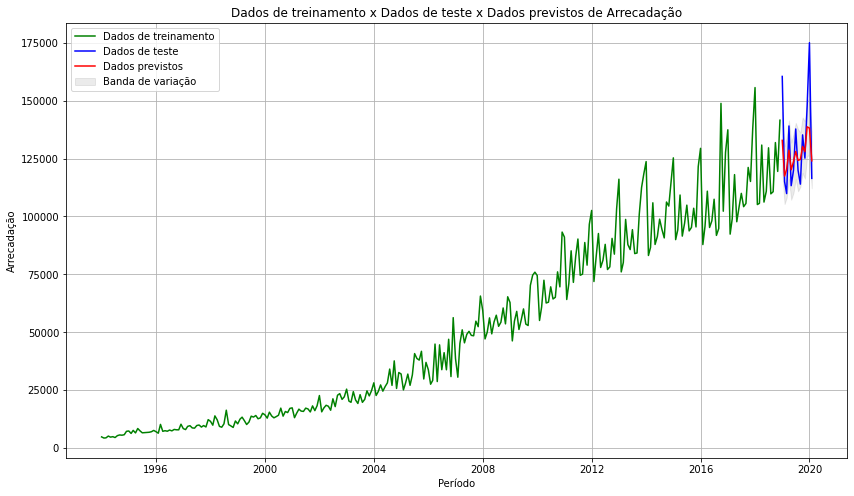

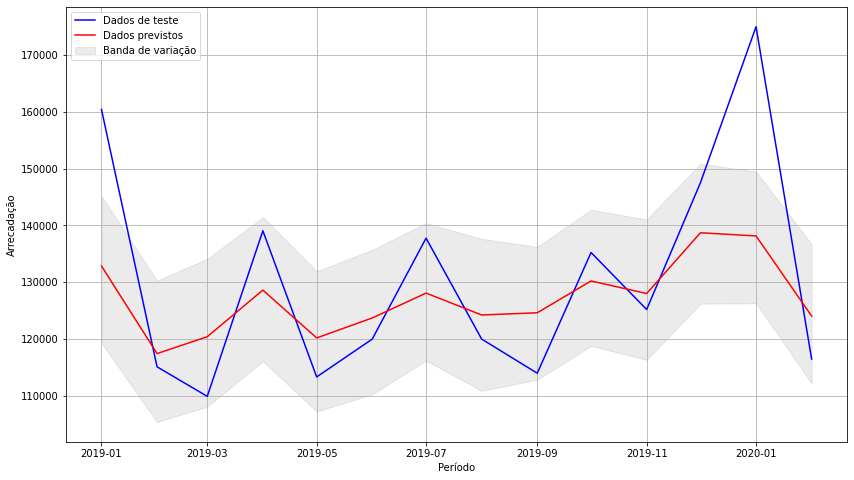

In [ ]:
#Plotagem do comparativo entre o preço previsto e o dataset
n = dfarrec_train_prophet.shape[0]
plt.figure(figsize=(14,8))
plt.title('Dados de treinamento x Dados de teste x Dados previstos de Arrecadação')
plt.plot(dfarrec_train_prophet['y'], 'green', label='Dados de treinamento')
plt.plot(dfarrec_test_prophet['y_test'], color = 'blue', label='Dados de teste')
plt.plot(prophet_forecast['yhat'][-n:], color = 'red', label = 'Dados previstos')
plt.fill_between(prophet_forecast.index[-n:], prophet_forecast['yhat_lower'][-n:], prophet_forecast['yhat_upper'][-n:], color='k', alpha=.08, label="Banda de variação")
plt.xlabel("Período")
plt.ylabel("Arrecadação")
plt.legend()
#plt.savefig('prophet1.pdf')
plt.grid(True)

#Plotagem do comparativo entre o preço previsto e o preço de validação
plt.figure(figsize=(14,8))
plt.plot(dfarrec_test_prophet['y_test'], color = 'blue', label='Dados de teste')
plt.plot(prophet_forecast['yhat'], color = 'red', label = 'Dados previstos')
plt.fill_between(prophet_forecast.index[-n:], prophet_forecast['yhat_lower'][-n:], prophet_forecast['yhat_upper'][-n:], color='k', alpha=.08, label="Banda de variação")
plt.xlabel("Período")
plt.ylabel("Arrecadação")
plt.legend()
plt.grid(True)
#plt.savefig('prophet2.pdf')
plt.show()

In [ ]:
#Cálculo do erro
print('MAE: ', mean_absolute_error(dfarrec_test_prophet['y_test'],prophet_forecast['yhat']))
print('MSE: ', mean_squared_error(dfarrec_test_prophet['y_test'],prophet_forecast['yhat']))
print('RMSE: ', np.sqrt(mean_squared_error(dfarrec_test_prophet['y_test'],prophet_forecast['yhat'])))

MAE:  10510.587230358593
MSE:  200026457.37499568
RMSE:  14143.07100226099


## Comparativo entre os modelos

In [ ]:
rmse_errors = [arima_rmse_error, lstm_rmse_error, prophet_rmse_error]
mse_errors = [arima_mse_error, lstm_mse_error, prophet_mse_error]
errors = pd.DataFrame({"Models" : ["ARIMA", "LSTM", "Prophet"],"RMSE Errors" : rmse_errors, "MSE Errors" : mse_errors})

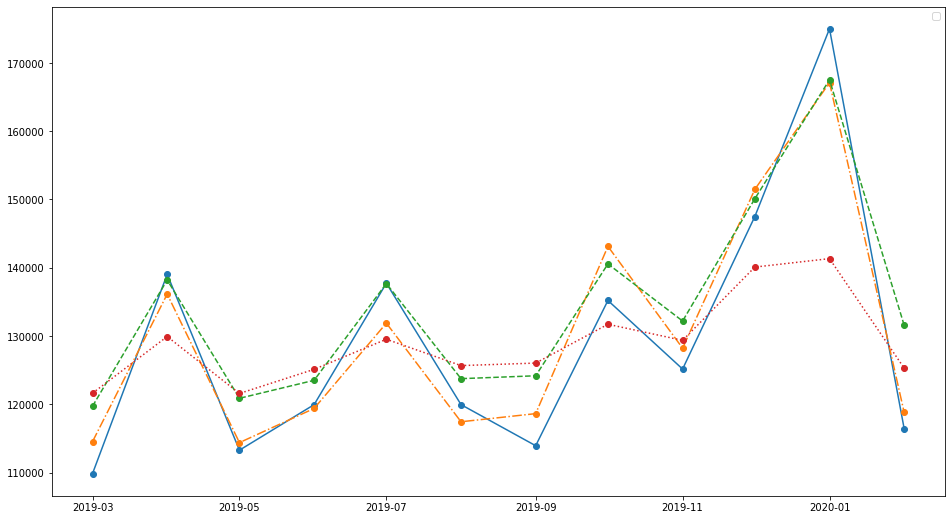

In [ ]:
plt.figure(figsize=(16,9))
plt.plot_date(test_data.index, test_data["y"], linestyle="-")
plt.plot_date(test_data.index, test_data["ARIMA_Predictions"], linestyle="-.")
plt.plot_date(test_data.index, test_data["LSTM_Predictions"], linestyle="--")
plt.plot_date(test_data.index, test_data["Prophet_Predictions"], linestyle=":")
plt.legend()
plt.show()

In [ ]:
print(f"Mean: {test_data['y'].mean()}")
errors

Mean: 129417.66666666667


Models   RMSE Errors    MSE Errors
0    ARIMA   4567.200703  2.085932e+07
1     LSTM   7404.772293  5.483065e+07
2  Prophet  12449.931929  1.550008e+08

In [ ]:
test_data

y  ARIMA_Predictions  LSTM_Predictions  Prophet_Predictions
ds                                                                          
2019-03-01  109854      114538.221536     119725.200061        121630.326801
2019-04-01  139030      136135.889426     138206.986727        129922.933794
2019-05-01  113278      114385.365859     120876.386910        121583.844712
2019-06-01  119946      119389.395546     123511.827040        125117.610239
2019-07-01  137735      131883.349396     137679.333062        129526.413885
2019-08-01  119951      117439.879777     123752.316615        125666.318949
2019-09-01  113933      118629.422669     124174.257203        126033.950733
2019-10-01  135202      143127.237904     140554.220802        131719.143913
2019-11-01  125161      128216.866629     132194.375215        129363.723922
2019-12-01  147501      151476.405793     150109.127467        140094.810948
2020-01-01  174991      167102.885630     167520.991363        141330.877965
2020-02-01  116430      118813.306616     131574.135389        125291.666429